## EDA

This notebook is using DATA_Texas_District_v1.csv to analyze: 
- Locale
- Poverty Proxy: Ttile 1, Free or Reduced Lunch elibility
- Race/Ethnicity
- Enrollment by Grades
- Covid: On-Campus, Infection and Deaths Rates
- ADA: Average Daily Attendance 
- STAAR: Tested Students, Learning Loss
- Census Block Group 2010: Race/Ethnicity, Gender, Age Group, Households, and Housing Units

Note: List of variables is [here](https://git.txstate.edu/DataLab/data-NCES/blob/master/CHERR/EDA/DATA_Texas_District_List_of_Variables.csv).   

Note: All raw data was processed/cleaned from [here](https://git.txstate.edu/DataLab/data-NCES/blob/master/data).

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# import warnings
# warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('DATA_Texas_District_v1.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1165 entries, 0 to 1164
Columns: 950 entries, Agency Name to Label_All
dtypes: float64(902), int64(45), object(3)
memory usage: 8.4+ MB


The data has missing values, especially from the STAAR data, that we are ignoring for EDA and handle at the end of this notebook for ML modeling and prediction

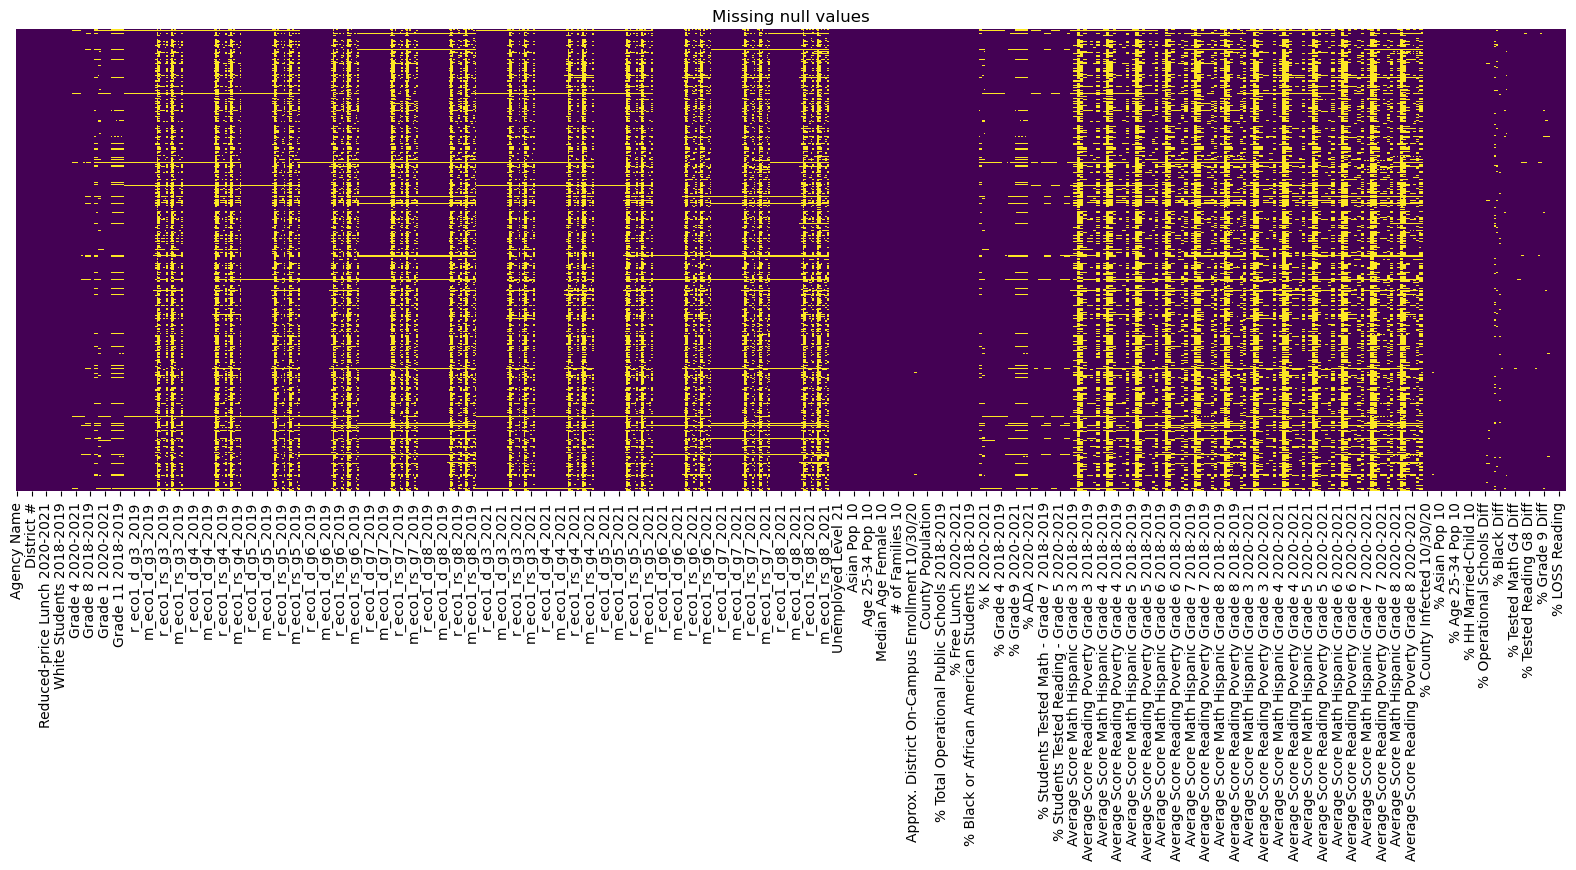

In [4]:
plt.rcParams['figure.figsize'] = (20,6)
sns.heatmap(df.isna(), yticklabels = False, cbar = False , cmap = 'viridis')
plt.title("Missing null values")
plt.show()

## Labeling ##   
Creating 3 classes for Learning Loss  
- Step 1: Learning Loss is calculated by averaging Average Score of all grades for Math and Reading separately and substracting the 2021 average from 2019 average.
- Step2: Get Percent Loss Different from 2019 to 2021 for the perspective of 2019. % LOSS = (AVG 2021 - AVG 2019)/AVG 2019
    - if '% Loss' Difference > 0, 2021 Learning is better than 2019, that is there is Learning Gain   
    - if '% Loss' Difference < 0, 2021 Learning is worse than 2019, that is there is Learning Loss
- Step 3: Decide threshold for labelings using `% LOSS Math` and `% LOSS Reading` separately.
    - 0 ***(Expected)***:  25th percentile <= x <= 75th percentile
    - 1 ***(Gain)***: 75th percentile < x
    - -1 ***(Loss)***:  x < 25th percentile

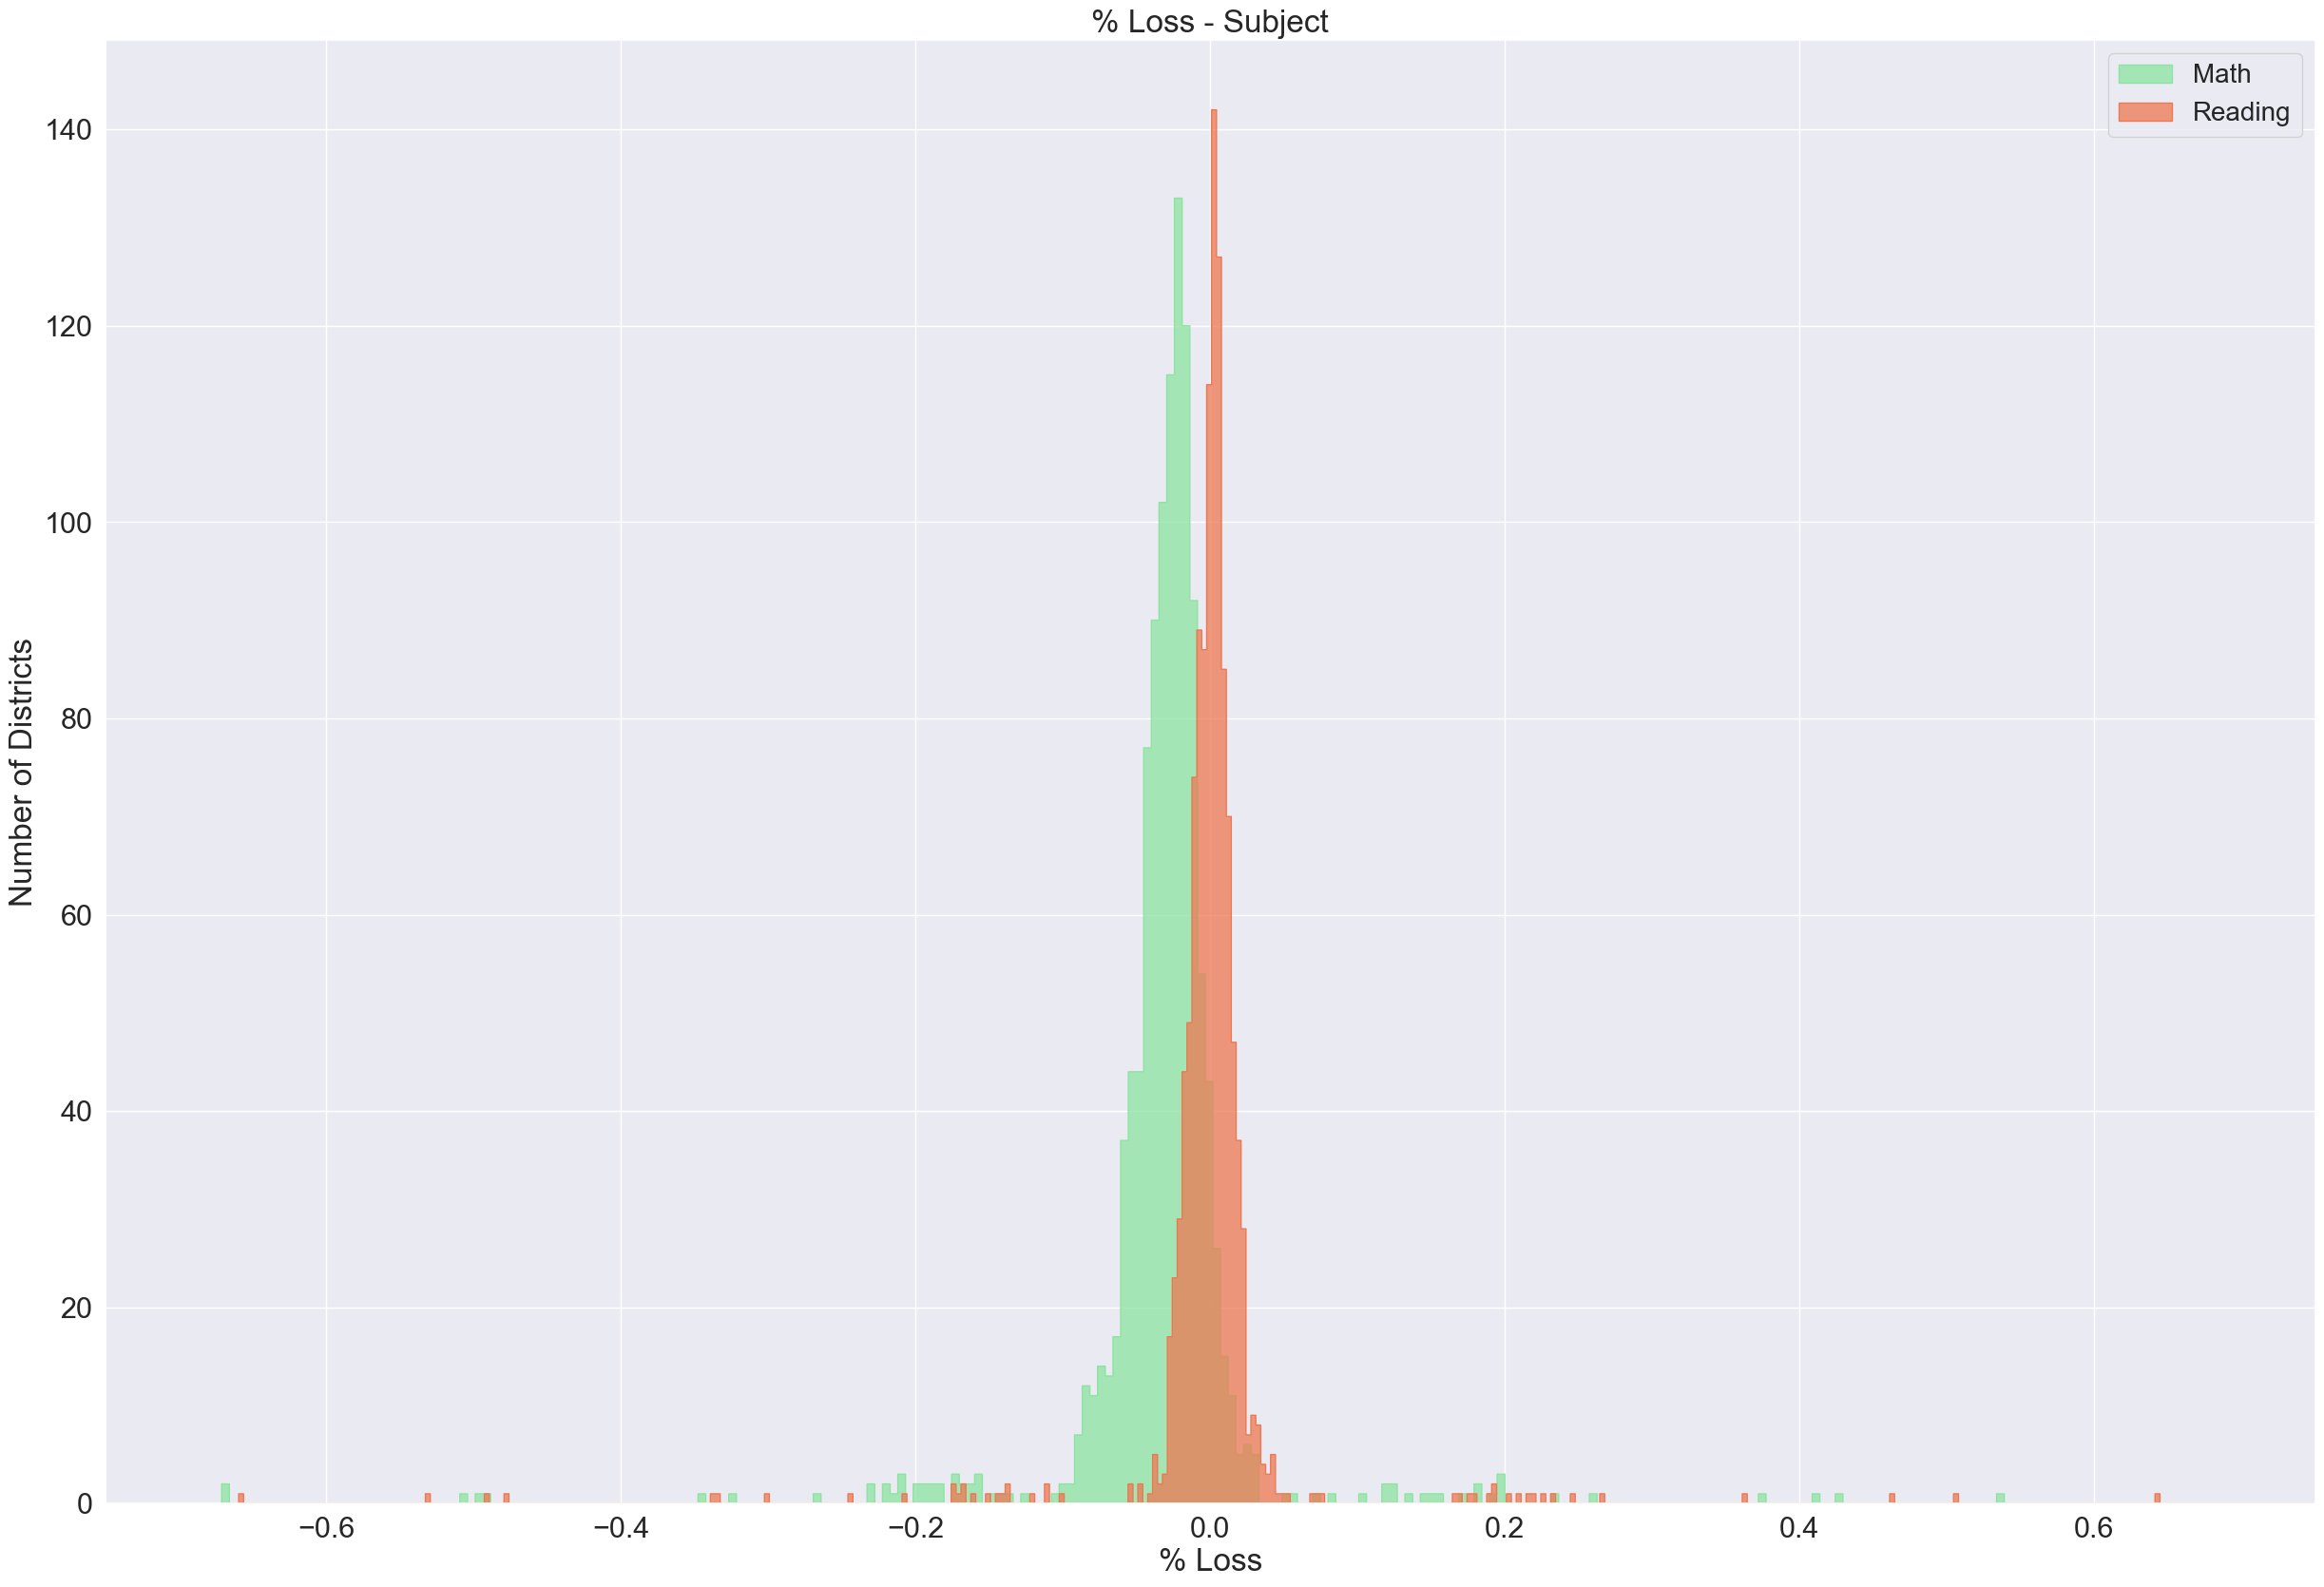

In [5]:
sns.set(rc={'figure.figsize':(30,20)})
sns.set(font_scale=2)

g = sns.histplot(data=df, x='% LOSS Math', shrink=0.8, color='#8de4a1', label='Math', element="step", stat="count")
g = sns.histplot(data=df, x='% LOSS Reading', shrink=0.8, color='#ed7953', label='Reading', element="step", stat="count")
g.set(xlabel='% Loss', ylabel='Number of Districts', title='% Loss - Subject')
g.set_xlim(-.75, .75)
plt.legend(loc='upper right', fontsize=20)
plt.show()

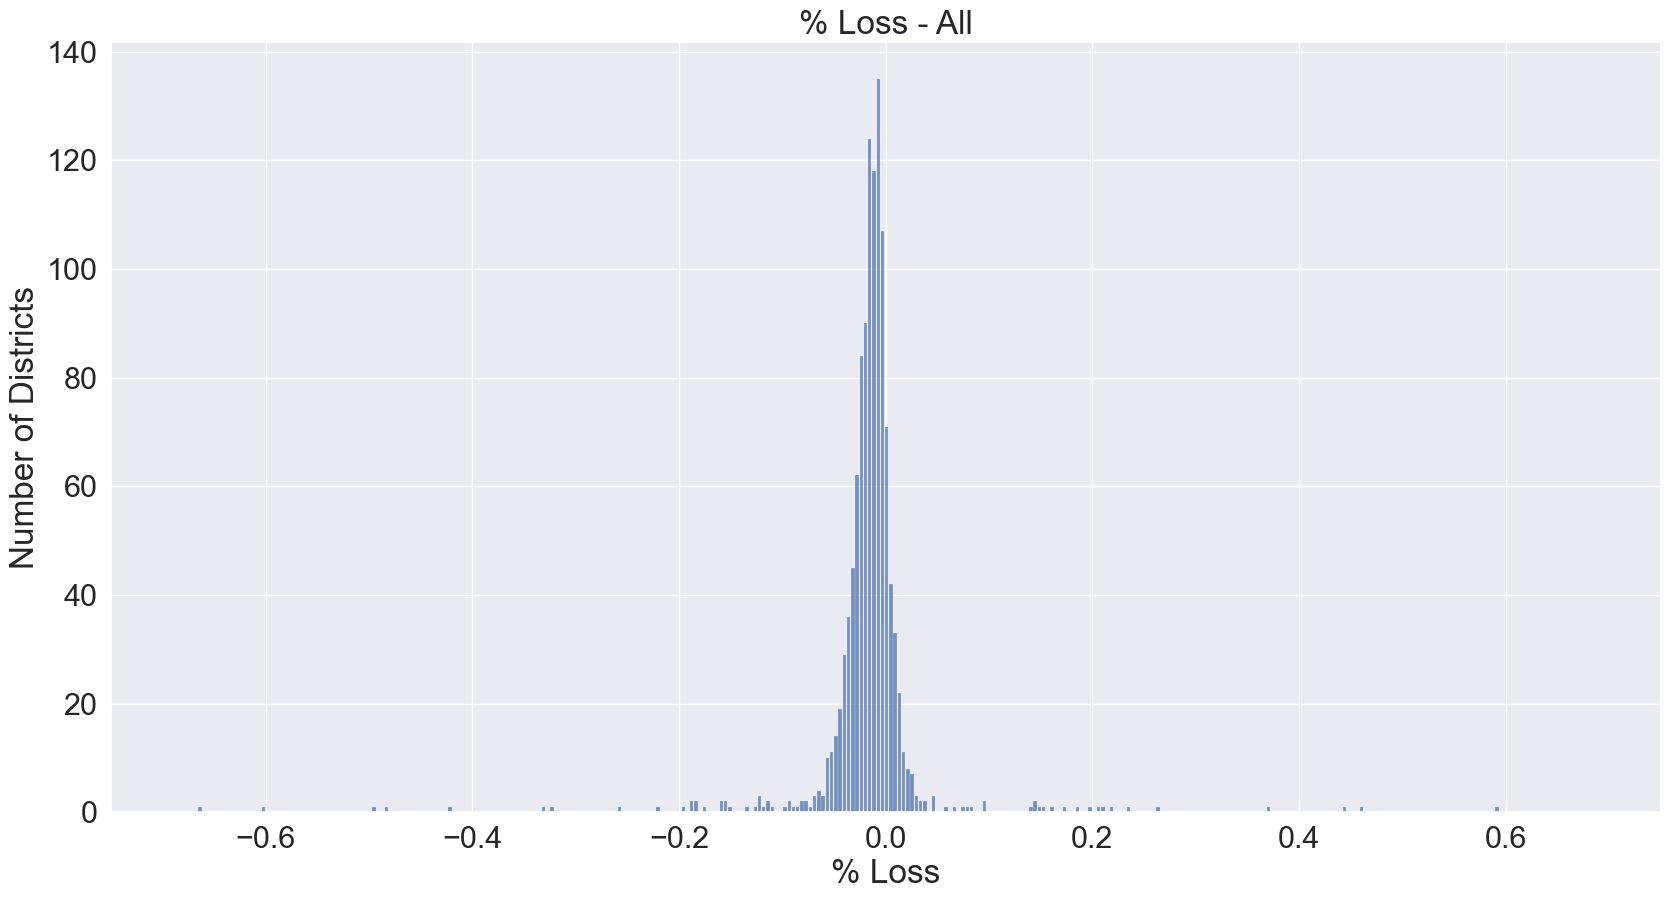

In [6]:
sns.set(rc={'figure.figsize':(20,10)})
sns.set(font_scale=2)

g = sns.histplot(data=df, x='% LOSS All', shrink=0.8, label='Math')
g.set(xlabel='% Loss', ylabel='Number of Districts', title='% Loss - All')
g.set_xlim(-.75, .75)

plt.show()

In [7]:
cols = ['% LOSS Math', '% LOSS Reading', '% LOSS All']
df[cols].describe()

,% LOSS Math,% LOSS Reading,% LOSS All
count,1165.000000,1165.000000,1165.000000
mean,-0.027535,0.003167,-0.012184
std,0.093510,0.090935,0.091248
min,-0.671508,-0.659782,-0.665645
25%,-0.042173,-0.008662,-0.024945
50%,-0.026848,0.001044,-0.013199
75%,-0.014706,0.008905,-0.003360
max,1.904820,1.981681,1.943251


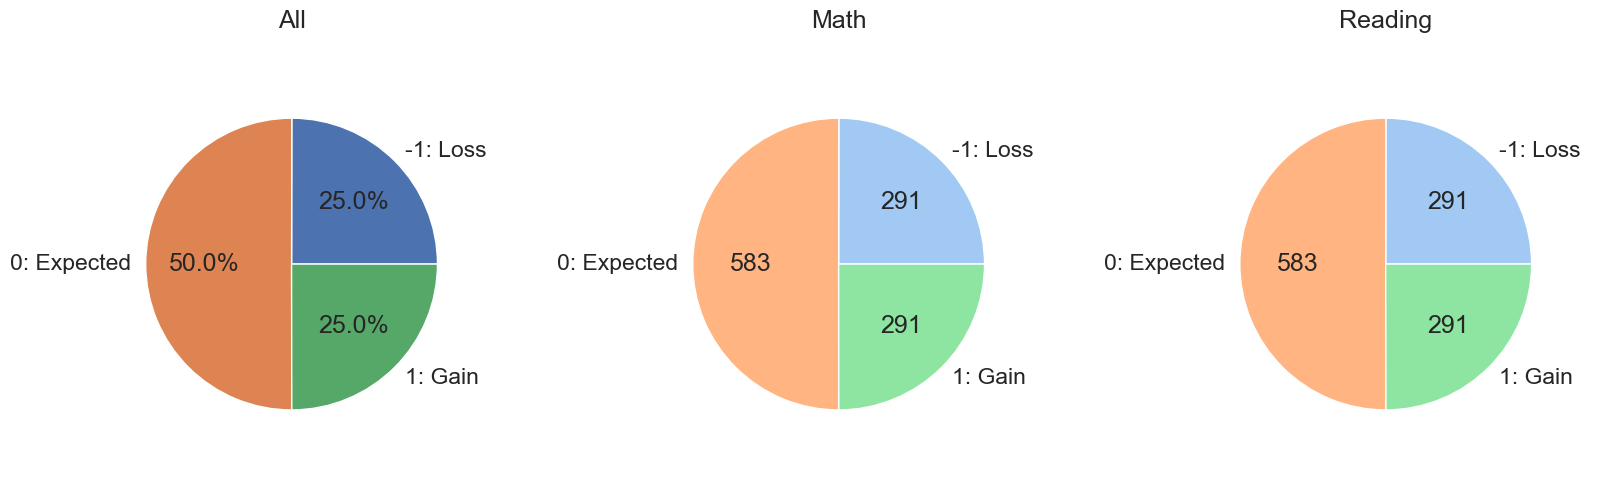

In [8]:
df_math = df['Label_Math'].value_counts().sort_index().to_frame()
df_math.reset_index(inplace=True)
df_math['label'] = df_math['index'].apply(lambda x: '-1: Loss' if x == -1
                                         else '0: Expected' if x == 0
                                         else '1: Gain' if x == 1
                                         else '-100')

df_reading = df['Label_Reading'].value_counts().sort_index().to_frame()
df_reading.reset_index(inplace=True)
df_reading['label'] = df_reading['index'].apply(lambda x: '-1: Loss' if x == -1
                                         else '0: Expected' if x == 0
                                         else '1: Gain' if x == 1
                                         else '-100')

df_all = df['Label_All'].value_counts().sort_index().to_frame()
df_all.reset_index(inplace=True)
df_all['label'] = df_all['index'].apply(lambda x: '-1: Loss' if x == -1
                                         else '0: Expected' if x == 0
                                         else '1: Gain' if x == 1
                                         else '-100')

fig, axes=plt.subplots(1,3, figsize=(20,10))
sns.set(font_scale=1.5)

colors=sns.color_palette('deep')[:df_all.shape[0]]
axes[0].pie(df_all['Label_All'], labels=df_all['label'], colors=colors, autopct='%1.1f%%', radius=.8)
axes[0].set(title='All')

colors=sns.color_palette('pastel')[:df_math.shape[0]]
axes[1].pie(df_math['Label_Math'], labels=df_math['label'], colors=colors, radius=.8,
            autopct=lambda p: '{:.0f}'.format(p*df_all['Label_All'].sum()/100))
axes[1].set(title='Math')

colors=sns.color_palette('pastel')[:df_reading.shape[0]]
axes[2].pie(df_reading['Label_Reading'], labels=df_reading['label'], colors=colors, radius=.8,
            autopct=lambda p: '{:.0f}'.format(p*df_all['Label_All'].sum()/100))
axes[2].set(title='Reading')

plt.show()

## EDA ##  
Now the data is ready for EDA. 

In [9]:
print('Number of District:', df['District #'].nunique())
print('Number of County:', df['County #'].nunique())
print('Number of Students in 2018-2019:', df['Total Students 2018-2019'].sum().astype('int'))
print('Number of Students in 2020-2021:', df['Total Students 2020-2021'].sum().astype('int'))
print('Number of Schools in 2018-2019:', df['Total Public Schools 2018-2019'].sum().astype('int'))
print('Number of Schools in 2020-2021:', df['Total Public Schools 2020-2021'].sum().astype('int'))

Number of District: 1165
Number of County: 253
Number of Students in 2018-2019: 5359965
Number of Students in 2020-2021: 5279240
Number of Schools in 2018-2019: 9230
Number of Schools in 2020-2021: 9234


### Locale - Math ###

In [10]:
df['LABEL'] = df['Label_Math']

df_copy = df[['Locale', 'LABEL']].copy()
df_copy['Locale_Short'] = df_copy['Locale'].apply(lambda x: x[x.find('-')+1 : x.find(':')])
df_copy.sort_values(by='Locale_Short', inplace=True)

t = pd.get_dummies(df_copy[['LABEL','Locale_Short']], columns=['Locale_Short'], prefix="Locale")
df_copy2 = t.groupby('LABEL', as_index=False).agg('sum')

labels = ['City', 'Rural', 'Suburb', 'Town']
total = df_copy['Locale_Short'].value_counts().sort_index().reset_index()

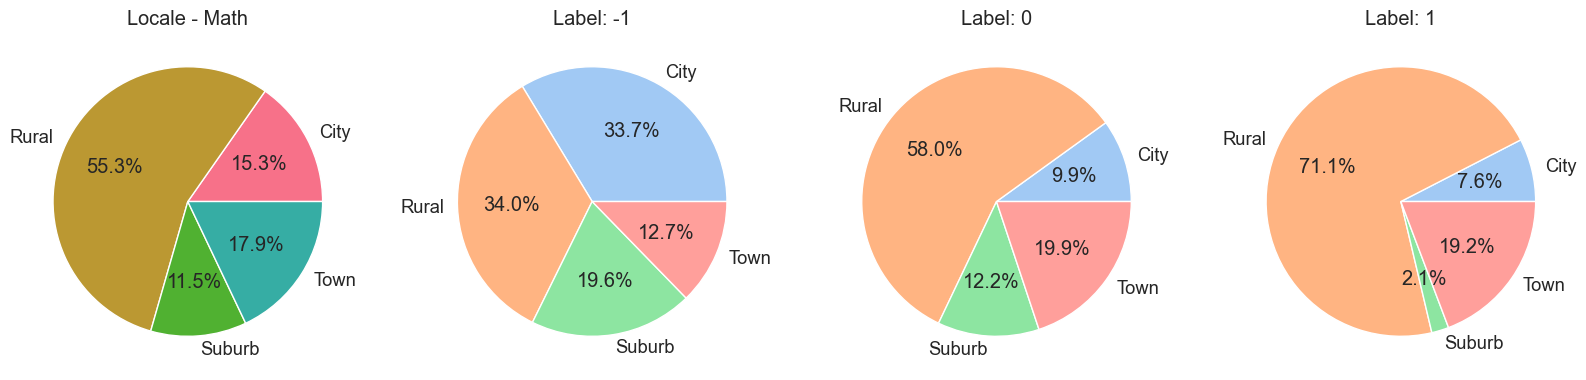

In [11]:
fig, axes = plt.subplots(1,df_copy2.shape[0]+1, figsize=(20,20))
sns.set(font_scale=1.2)

colors=sns.color_palette('husl')[:len(labels)]
axes[0].pie(total['Locale_Short'].to_list(), labels=labels, colors=colors, autopct='%1.1f%%')
axes[0].set(title='Locale - Math')

colors = sns.color_palette('pastel')[:len(labels)]

for loc in range(df_copy2.shape[0]):
    axes[loc+1].pie(df_copy2.iloc[loc, 1:5].to_list(), labels=labels, colors=colors, autopct='%1.1f%%')
    axes[loc+1].set(title='Label: ' + str(df_copy2['LABEL'][loc]))
    
plt.show()

### Locale - Reading ###

In [12]:
df['LABEL'] = df['Label_Reading']

df_copy = df[['Locale', 'LABEL']].copy()
df_copy['Locale_Short'] = df_copy['Locale'].apply(lambda x: x[x.find('-')+1 : x.find(':')])
df_copy.sort_values(by='Locale_Short', inplace=True)

t = pd.get_dummies(df_copy[['LABEL','Locale_Short']], columns=['Locale_Short'], prefix="Locale")
df_copy2 = t.groupby('LABEL', as_index=False).agg('sum')

labels = ['City', 'Rural', 'Suburb', 'Town']
total = df_copy['Locale_Short'].value_counts().sort_index().reset_index()

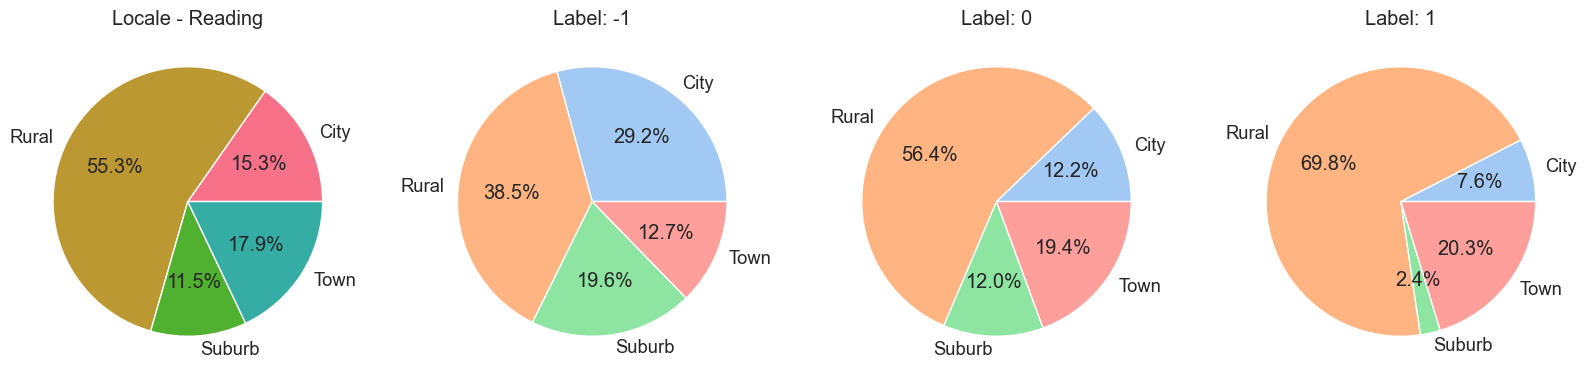

In [13]:
fig, axes = plt.subplots(1,df_copy2.shape[0]+1, figsize=(20,20))
sns.set(font_scale=1.2)

colors=sns.color_palette('husl')[:len(labels)]
axes[0].pie(total['Locale_Short'].to_list(), labels=labels, colors=colors, autopct='%1.1f%%')
axes[0].set(title='Locale - Reading')

colors = sns.color_palette('pastel')[:len(labels)]

for loc in range(df_copy2.shape[0]):
    axes[loc+1].pie(df_copy2.iloc[loc, 1:5].to_list(), labels=labels, colors=colors, autopct='%1.1f%%')
    axes[loc+1].set(title='Label: ' + str(df_copy2['LABEL'][loc]))
    
plt.show()

### Poverty Proxy ###  

In [14]:
df_copy = pd.DataFrame({'Year': ['2019', '2021']})

df_copy['School-wide Title I'] = [df['% School-wide Title I 2018-2019'].mean(),
                                 df['% School-wide Title I 2020-2021'].mean()]

df_copy['Title I Eligible School'] = [df['% Title I Eligible School 2018-2019'].mean(),
                                 df['% Title I Eligible School 2020-2021'].mean()]

df_copy['Free Lunch'] = [df['% Free Lunch 2018-2019'].mean(),
                         df['% Free Lunch 2020-2021'].mean()]

df_copy['Reduced-price Lunch'] = [df['% Reduced-price Lunch 2018-2019'].mean(),
                                 df['% Reduced-price Lunch 2020-2021'].mean()]
df_copy

,Year,School-wide Title I,Title I Eligible School,Free Lunch,Reduced-price Lunch
0,2019,0.802485,0.837124,0.547998,0.055900
1,2021,0.817139,0.850159,0.550330,0.049328


**Title 1 Eligible Schools - Math**

In [15]:
df['LABEL'] = df['Label_Math']

cols = ['% School-wide Title I 2018-2019', '% School-wide Title I 2020-2021']

df_copy = df[['LABEL'] + cols].groupby('LABEL', as_index=False).agg('mean')

d = []
for col in cols: 
    temp = df_copy[['LABEL', col]].copy()
    temp.rename(columns={col: 'School-wide Title I'}, inplace=True)
    temp['year'] =  col[-4:]
    d.append(temp)

df_copy2 = pd.concat(d)

In [16]:
cols = ['% Title I Eligible School 2018-2019', '% Title I Eligible School 2020-2021']

df_copy = df[['LABEL'] + cols].groupby('LABEL', as_index=False).agg('mean')

d = []
for col in cols: 
    temp = df_copy[['LABEL', col]].copy()
    temp.rename(columns={col: 'Title 1 Eligible School'}, inplace=True)
    temp['year'] =  col[-4:]
    d.append(temp)

df_copy3 = pd.concat(d)

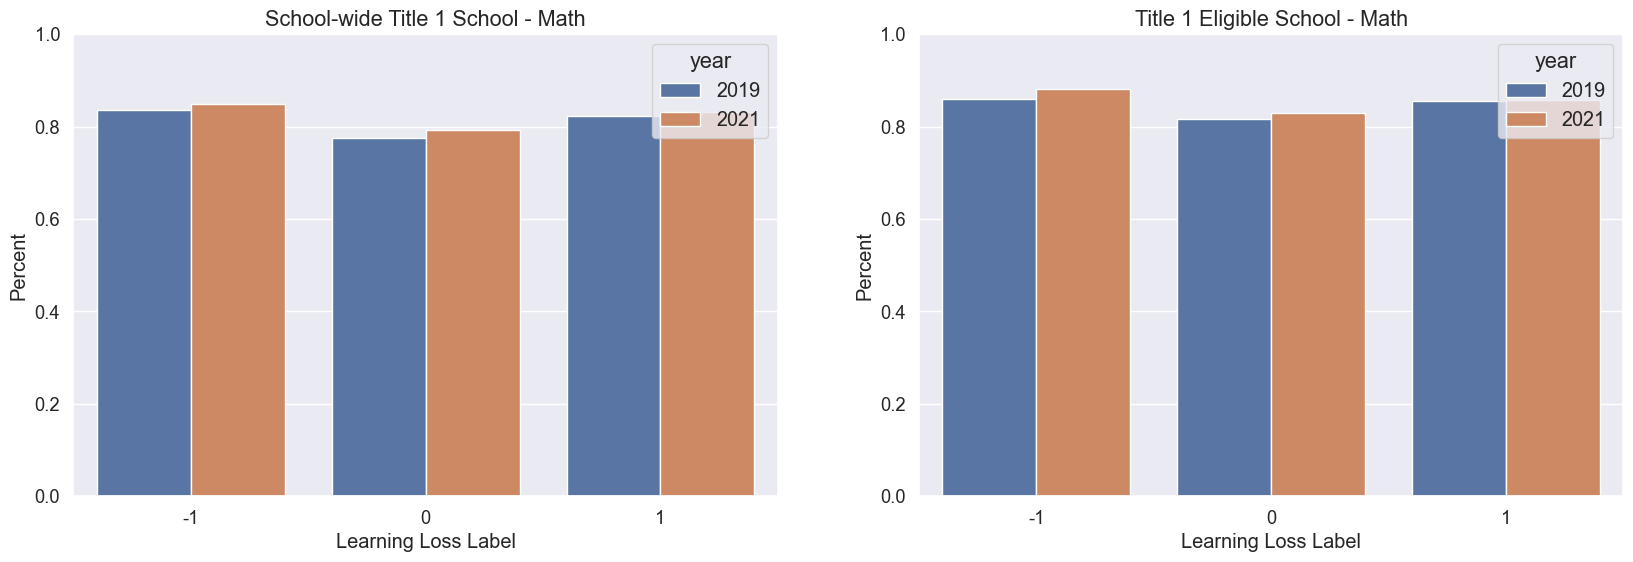

In [17]:
fig, axes=plt.subplots(1,2, figsize=(20, 6))
sns.set(font_scale=1.3)

sns.barplot(ax=axes[0], data=df_copy2, x="LABEL", y="School-wide Title I", hue="year", palette="deep")
axes[0].set(title='School-wide Title 1 School - Math', xlabel='Learning Loss Label', ylabel='Percent')
axes[0].set_ylim(0, 1)

sns.barplot(ax=axes[1], data=df_copy3, x="LABEL", y="Title 1 Eligible School", hue="year", palette="deep")
axes[1].set(title='Title 1 Eligible School - Math', xlabel='Learning Loss Label', ylabel='Percent')
axes[1].set_ylim(0, 1)

plt.show()

**Title 1 Eligible Schools - Reading**

In [18]:
df['LABEL'] = df['Label_Reading']

cols = ['% School-wide Title I 2018-2019', '% School-wide Title I 2020-2021']

df_copy = df[['LABEL'] + cols].groupby('LABEL', as_index=False).agg('mean')

d = []
for col in cols: 
    temp = df_copy[['LABEL', col]].copy()
    temp.rename(columns={col: 'School-wide Title I'}, inplace=True)
    temp['year'] =  col[-4:]
    d.append(temp)

df_copy2 = pd.concat(d)

In [19]:
cols = ['% Title I Eligible School 2018-2019', '% Title I Eligible School 2020-2021']

df_copy = df[['LABEL'] + cols].groupby('LABEL', as_index=False).agg('mean')

d = []
for col in cols: 
    temp = df_copy[['LABEL', col]].copy()
    temp.rename(columns={col: 'Title 1 Eligible School'}, inplace=True)
    temp['year'] =  col[-4:]
    d.append(temp)

df_copy3 = pd.concat(d)

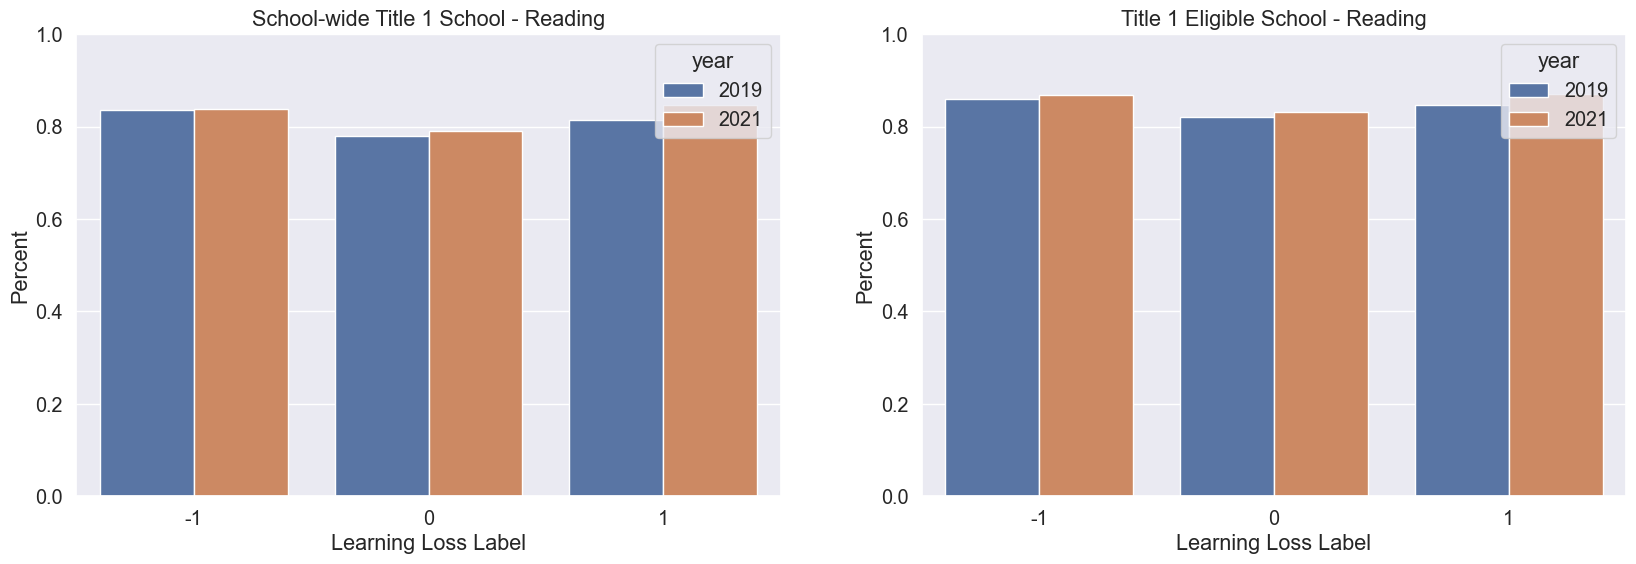

In [20]:
fig, axes=plt.subplots(1,2, figsize=(20, 6))
sns.set(font_scale=1.3)

sns.barplot(ax=axes[0], data=df_copy2, x="LABEL", y="School-wide Title I", hue="year", palette="deep")
axes[0].set(title='School-wide Title 1 School - Reading', xlabel='Learning Loss Label', ylabel='Percent')
axes[0].set_ylim(0, 1)

sns.barplot(ax=axes[1], data=df_copy3, x="LABEL", y="Title 1 Eligible School", hue="year", palette="deep")
axes[1].set(title='Title 1 Eligible School - Reading', xlabel='Learning Loss Label', ylabel='Percent')
axes[1].set_ylim(0, 1)

plt.show()

**Free Lunch/Reduced-price Lunch Eligible Schools - Math**

In [21]:
df['LABEL'] = df['Label_Math']
   
cols = ['% Free Lunch 2018-2019', '% Free Lunch 2020-2021']

df_copy = df[['LABEL'] + cols].groupby('LABEL', as_index=False).agg('mean')

d = []
for col in cols: 
    temp = df_copy[['LABEL', col]].copy()
    temp.rename(columns={col: 'Free Lunch'}, inplace=True)
    temp['year'] =  col[-4:]
    d.append(temp)

df_copy2 = pd.concat(d)

In [22]:
cols = ['% Reduced-price Lunch 2018-2019', '% Reduced-price Lunch 2020-2021']

df_copy = df[['LABEL'] + cols].groupby('LABEL', as_index=False).agg('mean')

d = []
for col in cols: 
    temp = df_copy[['LABEL', col]].copy()
    temp.rename(columns={col: 'Reduced-price Lunch'}, inplace=True)
    temp['year'] =  col[-4:]
    d.append(temp)

df_copy3 = pd.concat(d)

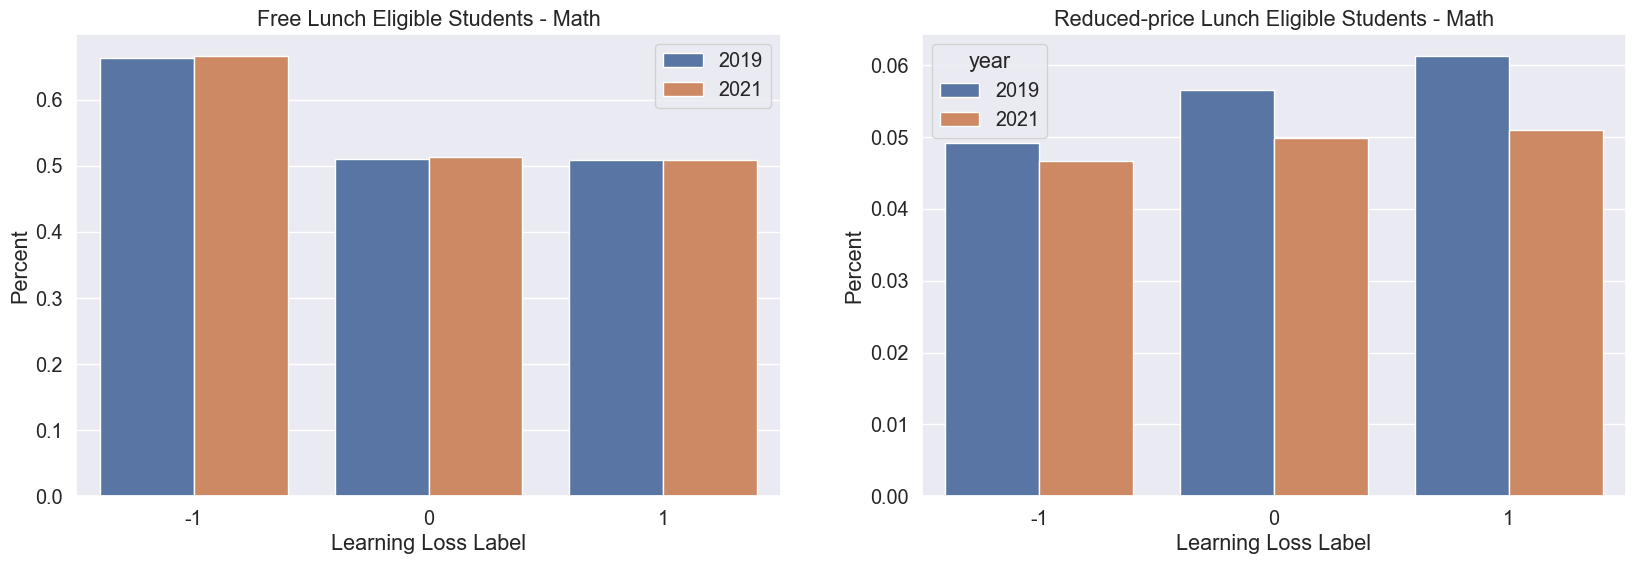

In [23]:
fig, axes=plt.subplots(1,2, figsize=(20, 6))
sns.set(font_scale=1.3)

sns.barplot(ax=axes[0], data=df_copy2, x="LABEL", y="Free Lunch", hue="year", palette="deep")
axes[0].set(title='Free Lunch Eligible Students - Math', xlabel='Learning Loss Label', ylabel='Percent')
# axes[0].set_ylim(0, 0.7)
axes[0].legend(loc='best')

sns.barplot(ax=axes[1], data=df_copy3, x="LABEL", y="Reduced-price Lunch", hue="year", palette="deep")
axes[1].set(title='Reduced-price Lunch Eligible Students - Math', xlabel='Learning Loss Label', ylabel='Percent')
# axes[1].set_ylim(0, 0.7)

plt.show()

**Free Lunch/Reduced-price Lunch Eligible Schools - Reading**

In [24]:
df['LABEL'] = df['Label_Reading']
   
cols = ['% Free Lunch 2018-2019', '% Free Lunch 2020-2021']

df_copy = df[['LABEL'] + cols].groupby('LABEL', as_index=False).agg('mean')

d = []
for col in cols: 
    temp = df_copy[['LABEL', col]].copy()
    temp.rename(columns={col: 'Free Lunch'}, inplace=True)
    temp['year'] =  col[-4:]
    d.append(temp)

df_copy2 = pd.concat(d)

In [25]:
cols = ['% Reduced-price Lunch 2018-2019', '% Reduced-price Lunch 2020-2021']

df_copy = df[['LABEL'] + cols].groupby('LABEL', as_index=False).agg('mean')

d = []
for col in cols: 
    temp = df_copy[['LABEL', col]]
    temp.rename(columns={col: 'Reduced-price Lunch'}, inplace=True)
    temp['year'] =  col[-4:]
    d.append(temp)

df_copy3 = pd.concat(d)

/var/folders/r0/cx28jby50vv14k5xp2yrpdkm0000gn/T/ipykernel_2505/631575899.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp.rename(columns={col: 'Reduced-price Lunch'}, inplace=True)
/var/folders/r0/cx28jby50vv14k5xp2yrpdkm0000gn/T/ipykernel_2505/631575899.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp.rename(columns={col: 'Reduced-price Lunch'}, inplace=True)


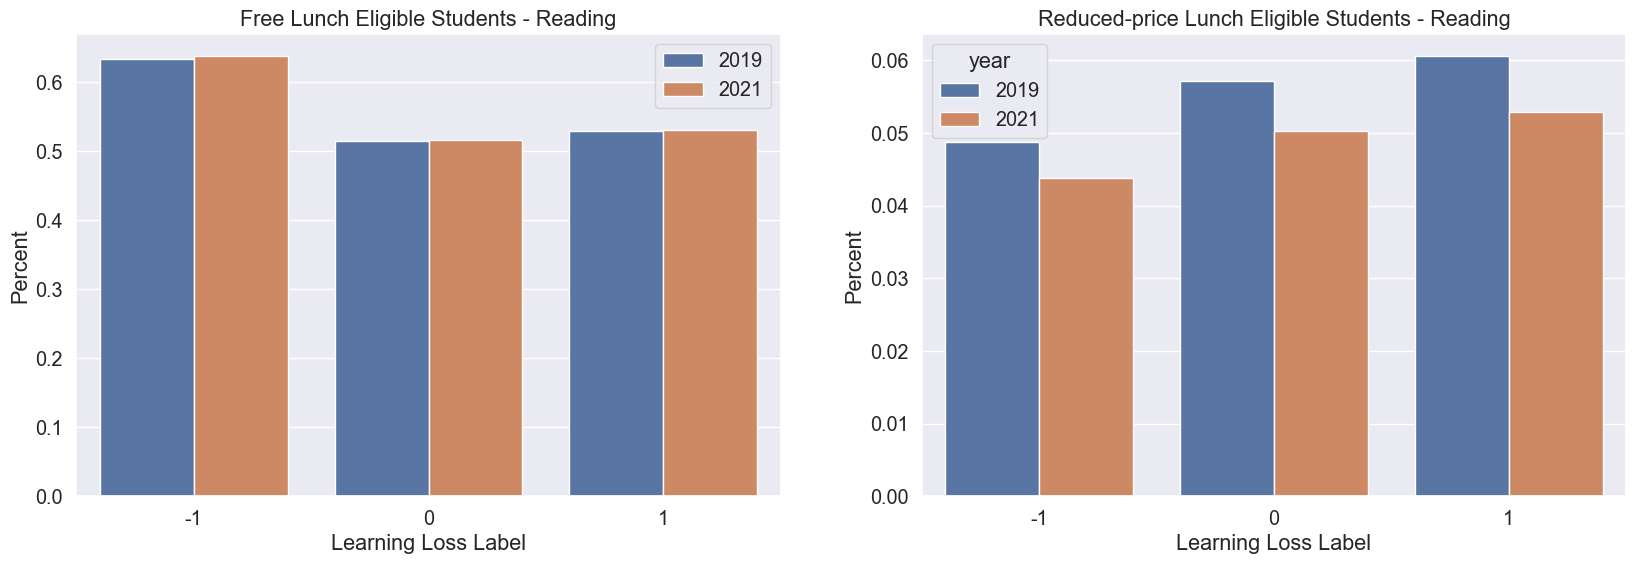

In [26]:
fig, axes=plt.subplots(1,2, figsize=(20, 6))
sns.set(font_scale=1.3)

sns.barplot(ax=axes[0], data=df_copy2, x="LABEL", y="Free Lunch", hue="year", palette="deep")
axes[0].set(title='Free Lunch Eligible Students - Reading', xlabel='Learning Loss Label', ylabel='Percent')
# axes[0].set_ylim(0, 0.7)
axes[0].legend(loc='best')

sns.barplot(ax=axes[1], data=df_copy3, x="LABEL", y="Reduced-price Lunch", hue="year", palette="deep")
axes[1].set(title='Reduced-price Lunch Eligible Students - Reading', xlabel='Learning Loss Label', ylabel='Percent')
# axes[1].set_ylim(0, 0.7)

plt.show()

### Race/Ethnicity - Math ###

In [27]:
df['LABEL'] = df['Label_Math']

cols = ['Asian or Asian/Pacific Islander Students 2020-2021',
        'Asian or Asian/Pacific Islander Students 2018-2019',
        'Hispanic Students 2020-2021',
        'Hispanic Students 2018-2019',
        'Black or African American Students 2020-2021',
        'Black or African American Students 2018-2019',
        'White Students 2020-2021',
        'White Students 2018-2019']

df_copy = df[['LABEL'] + cols].groupby('LABEL', as_index=False).agg('sum')

labels = ['Asian', 'Hispanic', 'Black', 'White']

for label, loc in zip(labels, np.arange(0, len(cols), 2)):
    df_copy[label] = df_copy[cols[loc:loc+2]].mean(axis=1)

total = []
for race in labels: total.append(df_copy[race].sum())

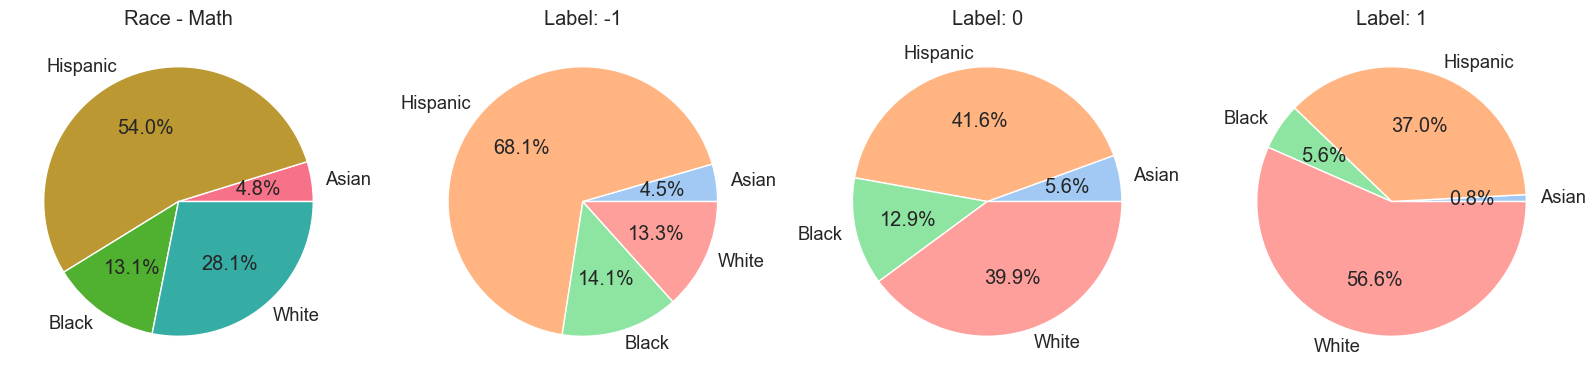

In [28]:
fig, axes = plt.subplots(1,df_copy.shape[0]+1, figsize=(20,20))
sns.set(font_scale=1.2)

colors=sns.color_palette('husl')[:len(labels)]
axes[0].pie(total, labels=labels, colors=colors, autopct='%1.1f%%')
axes[0].set(title='Race - Math')

colors = sns.color_palette('pastel')[:len(labels)]

for loc in range(df_copy.shape[0]):
    axes[loc+1].pie(df_copy[labels].loc[loc], labels=labels, colors=colors, autopct='%1.1f%%')
    axes[loc+1].set(title='Label: ' + str(df_copy['LABEL'][loc]))
    
plt.show()

### Race/Ethnicity - Reading ###

In [29]:
df['LABEL'] = df['Label_Reading']

cols = ['Asian or Asian/Pacific Islander Students 2020-2021',
        'Asian or Asian/Pacific Islander Students 2018-2019',
        'Hispanic Students 2020-2021',
        'Hispanic Students 2018-2019',
        'Black or African American Students 2020-2021',
        'Black or African American Students 2018-2019',
        'White Students 2020-2021',
        'White Students 2018-2019']

df_copy = df[['LABEL'] + cols].groupby('LABEL', as_index=False).agg('sum')

labels = ['Asian', 'Hispanic', 'Black', 'White']

for label, loc in zip(labels, np.arange(0, len(cols), 2)):
    df_copy[label] = df_copy[cols[loc:loc+2]].mean(axis=1)

total = []
for race in labels: total.append(df_copy[race].sum())

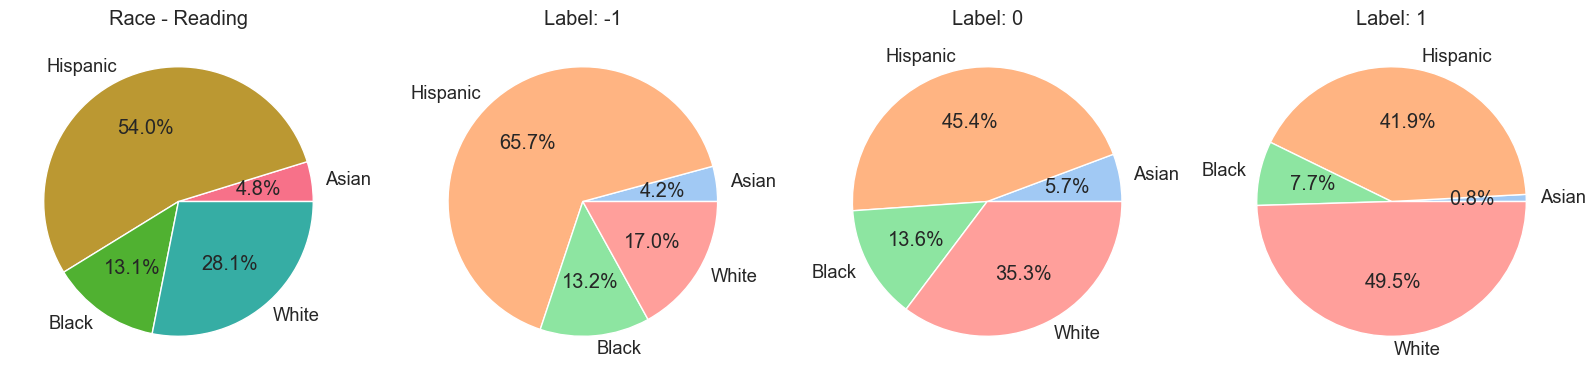

In [30]:
fig, axes = plt.subplots(1,df_copy.shape[0]+1, figsize=(20,20))
sns.set(font_scale=1.2)

colors=sns.color_palette('husl')[:len(labels)]
axes[0].pie(total, labels=labels, colors=colors, autopct='%1.1f%%')
axes[0].set(title='Race - Reading')

colors = sns.color_palette('pastel')[:len(labels)]

for loc in range(df_copy.shape[0]):
    axes[loc+1].pie(df_copy[labels].loc[loc], labels=labels, colors=colors, autopct='%1.1f%%')
    axes[loc+1].set(title='Label: ' + str(df_copy['LABEL'][loc]))
    
plt.show()

### Enrollment by Grades - Math ###

In [31]:
df['LABEL'] = df['Label_Math']

cols = ['Grades 1-8 2020-2021',
        'Grades 1-8 2018-2019',
        'Grades 9-12 2020-2021',
        'Grades 9-12 2018-2019',
        'Prek 2020-2021',
        'Prek 2018-2019',
        'K 2020-2021',
        'K 2018-2019']

df_copy = df[['LABEL'] + cols].groupby('LABEL', as_index=False).agg('sum')

labels = ['Grades 1-8', 'Grades 9-12', 'PreK', 'Kindergarten']

for label, loc in zip(labels, np.arange(0, len(cols), 2)):
    df_copy[label] = df_copy[cols[loc:loc+2]].mean(axis=1)

total = []
for grade in labels: total.append(df_copy[grade].sum())

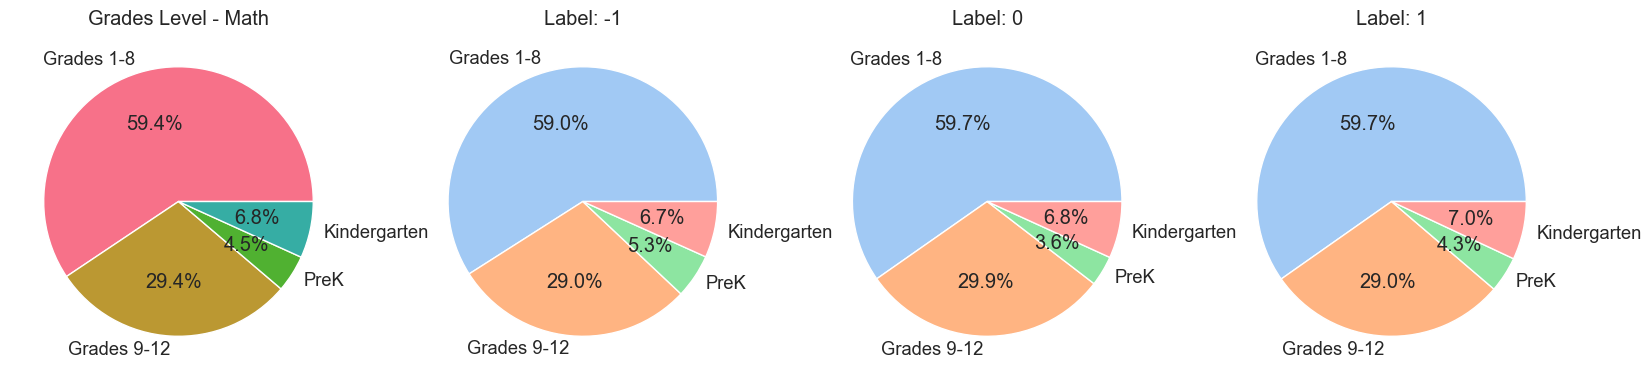

In [32]:
fig, axes = plt.subplots(1,df_copy.shape[0]+1, figsize=(20,20))
sns.set(font_scale=1.2)

colors=sns.color_palette('husl')[:len(labels)]
axes[0].pie(total, labels=labels, colors=colors, autopct='%1.1f%%')
axes[0].set(title='Grades Level - Math')

colors = sns.color_palette('pastel')[:len(labels)]

for loc in range(df_copy.shape[0]):
    axes[loc+1].pie(df_copy[labels].loc[loc], labels=labels, colors=colors, autopct='%1.1f%%')
    axes[loc+1].set(title='Label: ' + str(df_copy['LABEL'][loc]))
    
plt.show()

### Enrollment by Grades - Reading ###

In [33]:
df['LABEL'] = df['Label_Reading']

cols = ['Grades 1-8 2020-2021',
        'Grades 1-8 2018-2019',
        'Grades 9-12 2020-2021',
        'Grades 9-12 2018-2019',
        'Prek 2020-2021',
        'Prek 2018-2019',
        'K 2020-2021',
        'K 2018-2019']

df_copy = df[['LABEL'] + cols].groupby('LABEL', as_index=False).agg('sum')

labels = ['Grades 1-8', 'Grades 9-12', 'PreK', 'Kindergarten']

for label, loc in zip(labels, np.arange(0, len(cols), 2)):
    df_copy[label] = df_copy[cols[loc:loc+2]].mean(axis=1)

total = []
for grade in labels: total.append(df_copy[grade].sum())

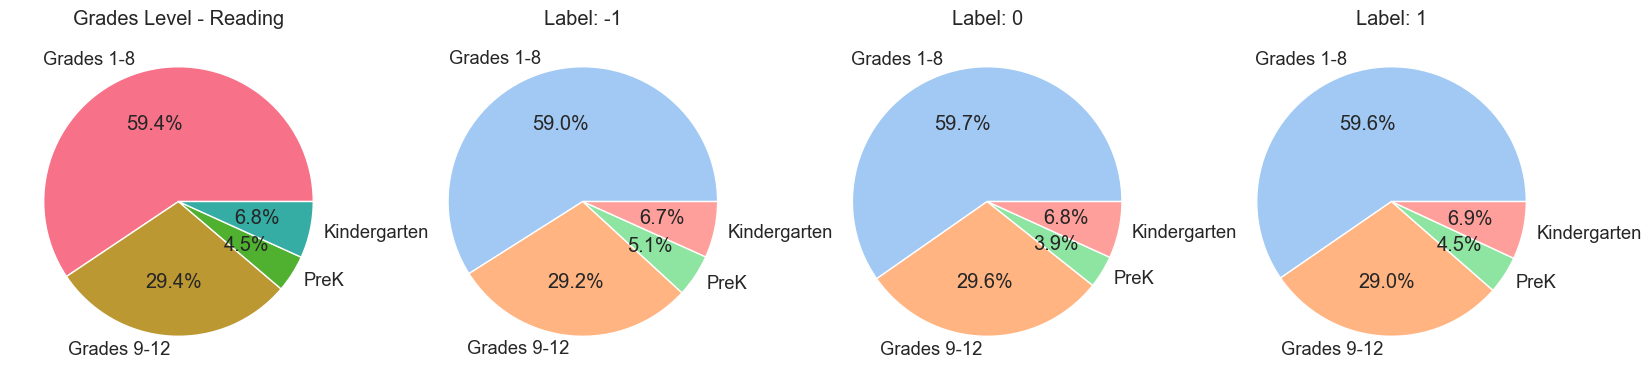

In [34]:
fig, axes = plt.subplots(1,df_copy.shape[0]+1, figsize=(20,20))
sns.set(font_scale=1.2)

colors=sns.color_palette('husl')[:len(labels)]
axes[0].pie(total, labels=labels, colors=colors, autopct='%1.1f%%')
axes[0].set(title='Grades Level - Reading')

colors = sns.color_palette('pastel')[:len(labels)]

for loc in range(df_copy.shape[0]):
    axes[loc+1].pie(df_copy[labels].loc[loc], labels=labels, colors=colors, autopct='%1.1f%%')
    axes[loc+1].set(title='Label: ' + str(df_copy['LABEL'][loc]))
    
plt.show()

### Covid - Math ###

In [35]:
df['LABEL'] = df['Label_Math']

cols = ['% On Campus 09/28/20', 
        '% On Campus 10/30/20',
        '% On Campus 01/29/21',
        '% County Infected 09/28/20',
        '% County Infected 10/30/20',
        '% County Infected 01/29/21',
        '% County Deaths 09/28/20',
        '% County Deaths 10/30/20',
        '% County Deaths 01/29/21']

labels = ['On-Campus', 'Infected', 'Deaths']
dates = ['09/28/20', '10/30/20', '01/29/21']

df_copy = pd.DataFrame()

for label, loc in zip(labels, np.arange(0, len(cols), 3)):
    df_temp = df[['LABEL'] + cols[loc:loc+3]].groupby('LABEL', as_index=False).agg('mean')
    new_names = dict(zip(cols[loc:loc+3], dates))
    df_temp.rename(columns = new_names, inplace=True)
    df_temp['Rates'] = label  
    df_copy = pd.concat([df_copy, df_temp])

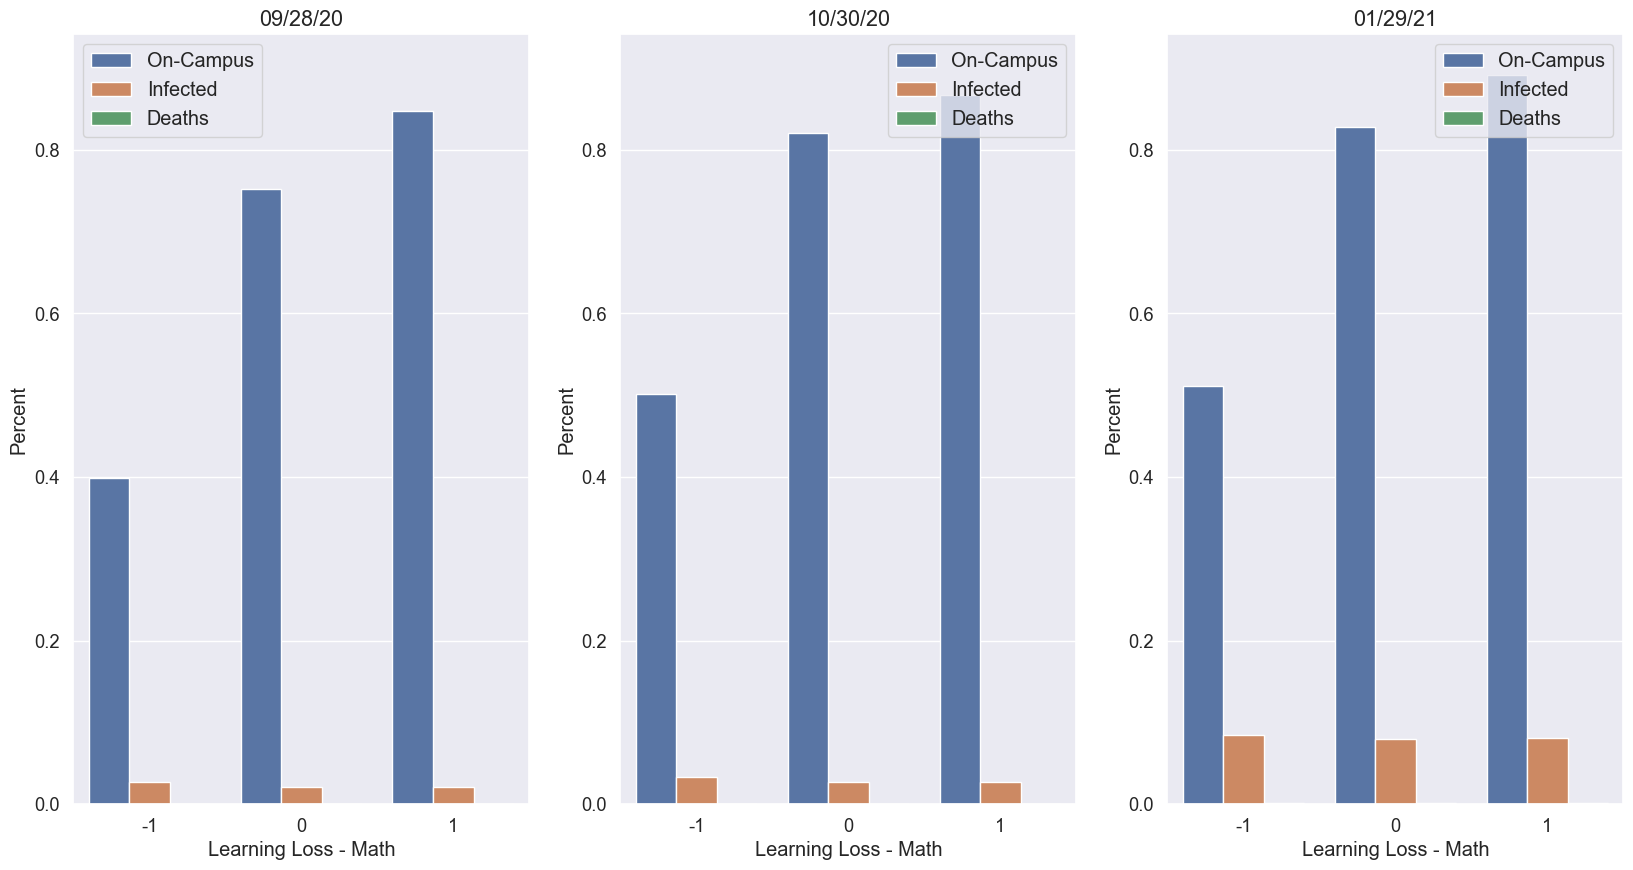

In [36]:
fig, axes=plt.subplots(1,3, figsize=(20, 10))
sns.set(font_scale=1.3)

for loc in range(3):
    sns.barplot(ax=axes[loc], data=df_copy, x="LABEL", y=dates[loc], hue="Rates", palette="deep", orient="v")
    axes[loc].set(title=dates[loc], xlabel='Learning Loss - Math', ylabel='Percent')
    axes[loc].set_ylim(0, df_copy[dates].values.max()+0.05)
    axes[loc].legend(loc='best')
plt.show()

### Covid - Reading ###

In [37]:
df['LABEL'] = df['Label_Reading']

cols = ['% On Campus 09/28/20', 
        '% On Campus 10/30/20',
        '% On Campus 01/29/21',
        '% County Infected 09/28/20',
        '% County Infected 10/30/20',
        '% County Infected 01/29/21',
        '% County Deaths 09/28/20',
        '% County Deaths 10/30/20',
        '% County Deaths 01/29/21']

labels = ['On-Campus', 'Infected', 'Deaths']
dates = ['09/28/20', '10/30/20', '01/29/21']

df_copy = pd.DataFrame()

for label, loc in zip(labels, np.arange(0, len(cols), 3)):
    df_temp = df[['LABEL'] + cols[loc:loc+3]].groupby('LABEL', as_index=False).agg('mean')
    new_names = dict(zip(cols[loc:loc+3], dates))
    df_temp.rename(columns = new_names, inplace=True)
    df_temp['Rates'] = label  
    df_copy = pd.concat([df_copy, df_temp])

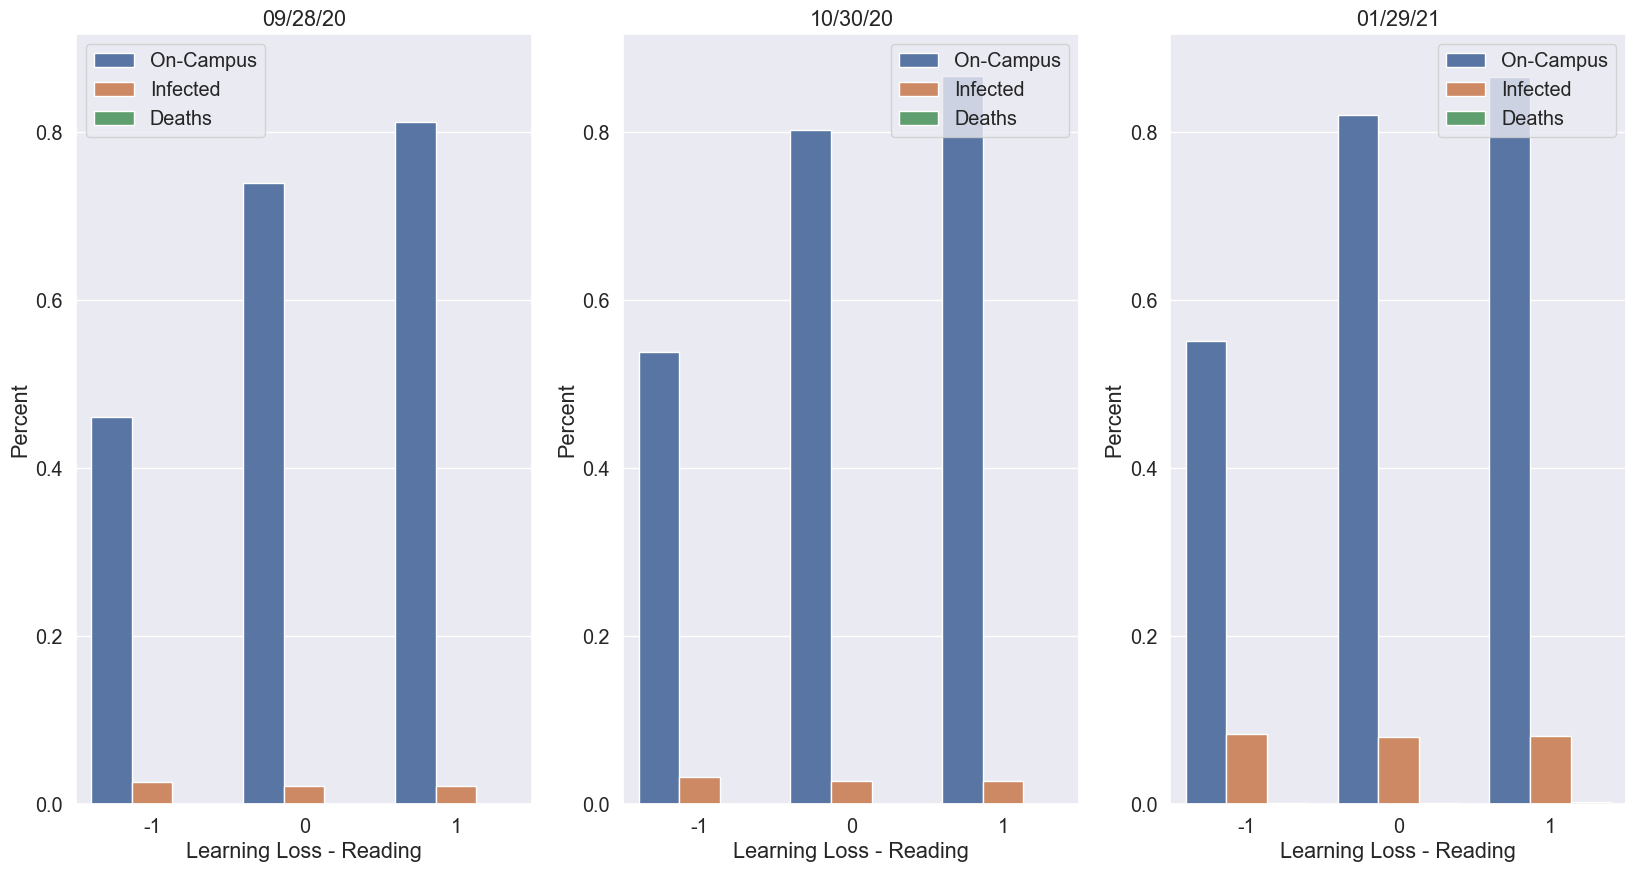

In [38]:
fig, axes=plt.subplots(1,3, figsize=(20, 10))
sns.set(font_scale=1.3)

for loc in range(3):
    sns.barplot(ax=axes[loc], data=df_copy, x="LABEL", y=dates[loc], hue="Rates", palette="deep", orient="v")
    axes[loc].set(title=dates[loc], xlabel='Learning Loss - Reading', ylabel='Percent')
    axes[loc].set_ylim(0, df_copy[dates].values.max()+0.05)
    axes[loc].legend(loc='best')
plt.show()

### ADA ###

In [39]:
#For Math
df['LABEL'] = df['Label_Math']

temp = df[df['% ADA 2018-2019'] <= 1]
df_copy1 = temp[['LABEL', '% ADA 2018-2019']].groupby('LABEL', as_index=False).agg('mean')
df_copy1.rename(columns={'% ADA 2018-2019': '% ADA'}, inplace=True)
df_copy1['Year'] = 2019

temp = df[df['% ADA 2020-2021'] <= 1]
df_copy2 = temp[['LABEL', '% ADA 2020-2021']].groupby('LABEL', as_index=False).agg('mean')
df_copy2.rename(columns={'% ADA 2020-2021': '% ADA'}, inplace=True)
df_copy2['Year'] = 2021

df_math = pd.concat([df_copy1, df_copy2])
df_math['Subject'] = 'Math'

# For Reading
df['LABEL'] = df['Label_Reading']

temp = df[df['% ADA 2018-2019'] <= 1]
df_copy1 = temp[['LABEL', '% ADA 2018-2019']].groupby('LABEL', as_index=False).agg('mean')
df_copy1.rename(columns={'% ADA 2018-2019': '% ADA'}, inplace=True)
df_copy1['Year'] = 2019

temp = df[df['% ADA 2020-2021'] <= 1]
df_copy2 = temp[['LABEL', '% ADA 2020-2021']].groupby('LABEL', as_index=False).agg('mean')
df_copy2.rename(columns={'% ADA 2020-2021': '% ADA'}, inplace=True)
df_copy2['Year'] = 2021

df_reading = pd.concat([df_copy1, df_copy2])
df_reading['Subject'] = 'Reading'

df_copy = pd.concat([df_math, df_reading])

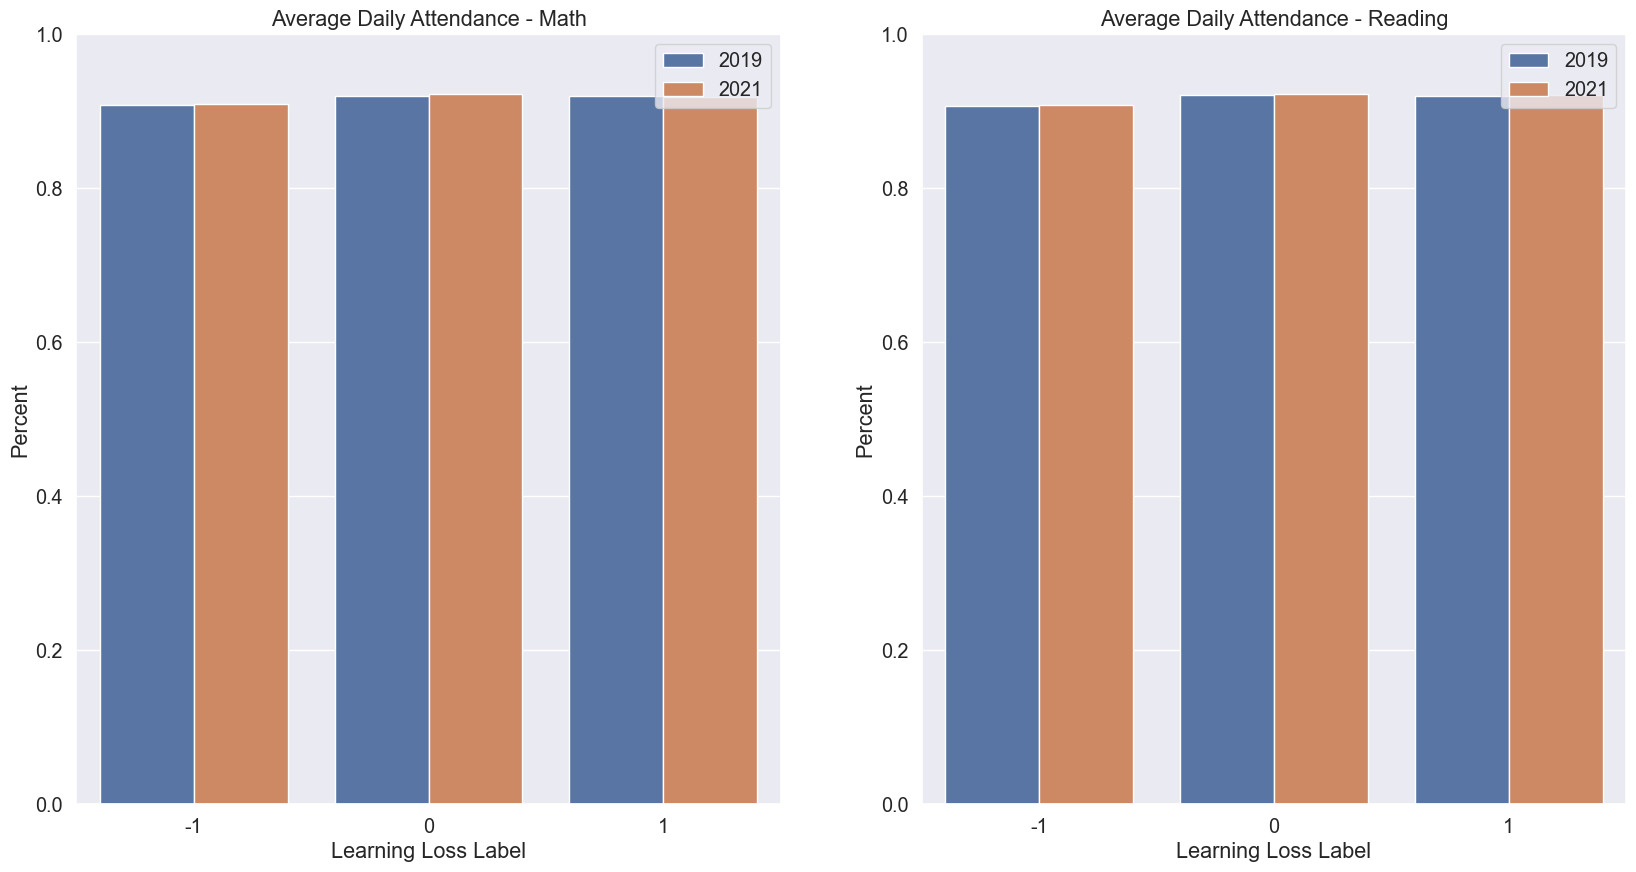

In [40]:
fig, axes=plt.subplots(1,2, figsize=(20, 10))
sns.set(font_scale=1.3)

for loc, subject in zip(range(2), ["Math", "Reading"]):
    data=df_copy[df_copy['Subject'] == subject]
    sns.barplot(ax=axes[loc], data=data, x="LABEL", y='% ADA', hue="Year",
                palette="deep", orient="v")
    axes[loc].set(title='Average Daily Attendance - ' + subject, xlabel='Learning Loss Label', ylabel='Percent')
    axes[loc].set_ylim(0, 1)
    axes[loc].legend(loc='best')
plt.show()

### STAAR Tested Students ###

- Students Tested Reading in 2018-2019

In [41]:
cols = ['% Students Tested Math - Grade 3 2020-2021',
        '% Students Tested Math - Grade 4 2020-2021',
        '% Students Tested Math - Grade 5 2020-2021',
        '% Students Tested Math - Grade 6 2020-2021',
        '% Students Tested Math - Grade 7 2020-2021',
        '% Students Tested Math - Grade 8 2020-2021',
        '% Students Tested Math - Grade 3 2018-2019',
        '% Students Tested Math - Grade 4 2018-2019',
        '% Students Tested Math - Grade 5 2018-2019',
        '% Students Tested Math - Grade 6 2018-2019',
        '% Students Tested Math - Grade 7 2018-2019',
        '% Students Tested Math - Grade 8 2018-2019',
        '% Students Tested Reading - Grade 3 2020-2021',
        '% Students Tested Reading - Grade 4 2020-2021',
        '% Students Tested Reading - Grade 5 2020-2021',
        '% Students Tested Reading - Grade 6 2020-2021',
        '% Students Tested Reading - Grade 7 2020-2021',
        '% Students Tested Reading - Grade 8 2020-2021',
        '% Students Tested Reading - Grade 3 2018-2019',
        '% Students Tested Reading - Grade 4 2018-2019',
        '% Students Tested Reading - Grade 5 2018-2019',
        '% Students Tested Reading - Grade 6 2018-2019',
        '% Students Tested Reading - Grade 7 2018-2019',
        '% Students Tested Reading - Grade 8 2018-2019']

df[cols] = df[cols].apply(lambda x: np.nan_to_num(x, posinf=0))
df_copy = df[cols].agg('mean').to_frame().reset_index()
df_copy['Year'] = df_copy['index'].apply(lambda x: str(x[-4:]))
df_copy['Grade'] = df_copy['index'].apply(lambda x: int(x[x.find("Grade")+5:x.find("Grade")+7]))
df_copy['Subject'] = df_copy['index'].apply(lambda x: str(x[x.find("Tested")+7:x.find(" - ")]))
df_copy.rename(columns={'index': 'variable', 0: '% Students Tested'}, inplace=True)

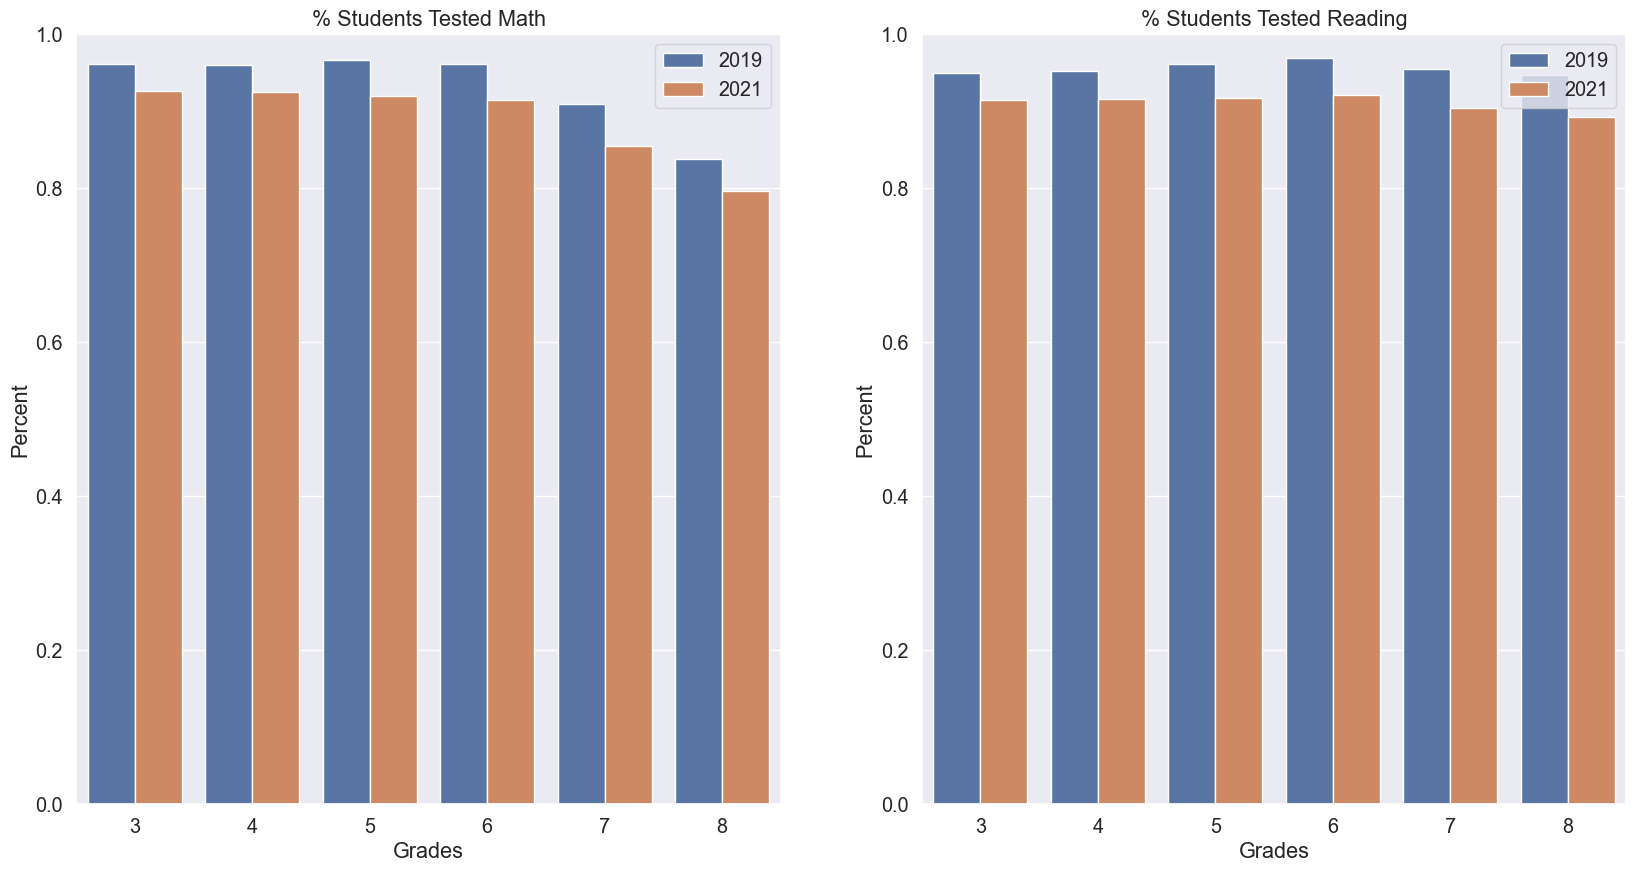

In [42]:
fig, axes=plt.subplots(1,2, figsize=(20, 10))
sns.set(font_scale=1.3)

for loc, subject in zip(range(2), ["Math", "Reading"]):
    data=df_copy[df_copy['Subject'] == subject]
    sns.barplot(ax=axes[loc], data=data, x="Grade", y='% Students Tested', hue="Year", hue_order=['2019', '2021'],
                palette="deep", orient="v")
    axes[loc].set(title='% Students Tested ' + subject, xlabel='Grades', ylabel='Percent')
    axes[loc].set_ylim(0, 1)
    axes[loc].legend(loc='best')
plt.show()

### STAAR Learning Loss ###

In [43]:
# Step 1. Create dataframe df_loss calculating Average Score difference from 2019 to 2021.

df_loss = df[['District #', 'County #', 'LABEL']]

groups = ['All', 'T1', 'Poverty', 'Free Lunch', 'Special Ed', 'Hispanic', 'Black', 'White', 'Asian']

for subject in ['Math', 'Reading']:
    for group in groups: 
        for grade in ['3', '4', '5', '6', '7', '8']:
            col = "Average Score " + subject + " " + group + " Grade " + grade
#             df_loss['% LOSS ' + col] = (df[col + ' 2018-2019'] - df[col + ' 2020-2021'])# / df[col + ' 2020-2021']
            df_loss['% LOSS ' + col] = (df[col + ' 2020-2021'] - df[col + ' 2018-2019'])# / df[col + ' 2020-2021']

/var/folders/r0/cx28jby50vv14k5xp2yrpdkm0000gn/T/ipykernel_2505/3691346056.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loss['% LOSS ' + col] = (df[col + ' 2020-2021'] - df[col + ' 2018-2019'])# / df[col + ' 2020-2021']
/var/folders/r0/cx28jby50vv14k5xp2yrpdkm0000gn/T/ipykernel_2505/3691346056.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loss['% LOSS ' + col] = (df[col + ' 2020-2021'] - df[col + ' 2018-2019'])# / df[col + ' 2020-2021']
/var/folders/r0/cx28jby50vv14k5xp2yrpdkm0000gn/T/i

- % Learning Loss between 2018-2019 and 2020-2021 by each student group and grade

In [44]:
#Get columns excluding 'District #', 'County #', 'LABEL'
cols_score = list(set(df_loss.columns.to_list()) - set(['District #', 'County #', 'LABEL']))

#Get list of District # 
cols_dist = df_loss['District #'].to_list()

#New column name mapping for transposed dataframe
cols1 = ['index'] + list(range(len(cols_dist)))
cols2 = ['variable'] + cols_dist 
new_cols = dict(zip(cols1, cols2))

In [45]:
# Step 2. Transpose dataframe df_loss, Rows are each variable and Columns are each district.

df_loss_t = df_loss[cols_score].T
df_loss_t.reset_index(inplace=True)
df_loss_t.rename(columns=new_cols, inplace=True)

# Extract Grade from 'variable' column
df_loss_t['grade'] = df_loss_t['variable'].apply(lambda x: int(x[-1]))

# Extract Group from 'variable' column
import re
df_loss_t['group'] = df_loss_t['variable'].apply(lambda x: re.findall("[M|R].+? (.+?) Grade", x)[0])

# Extract Subject from 'variable' column
df_loss_t['subject'] = df_loss_t['variable'].apply(lambda x: re.findall("Average Score (.+?)\s", x)[0])

# Get Average of % LOSS for all districts
df_loss_t['AVG'] = df_loss_t[cols_dist].apply(lambda x: x.mean(), axis=1)

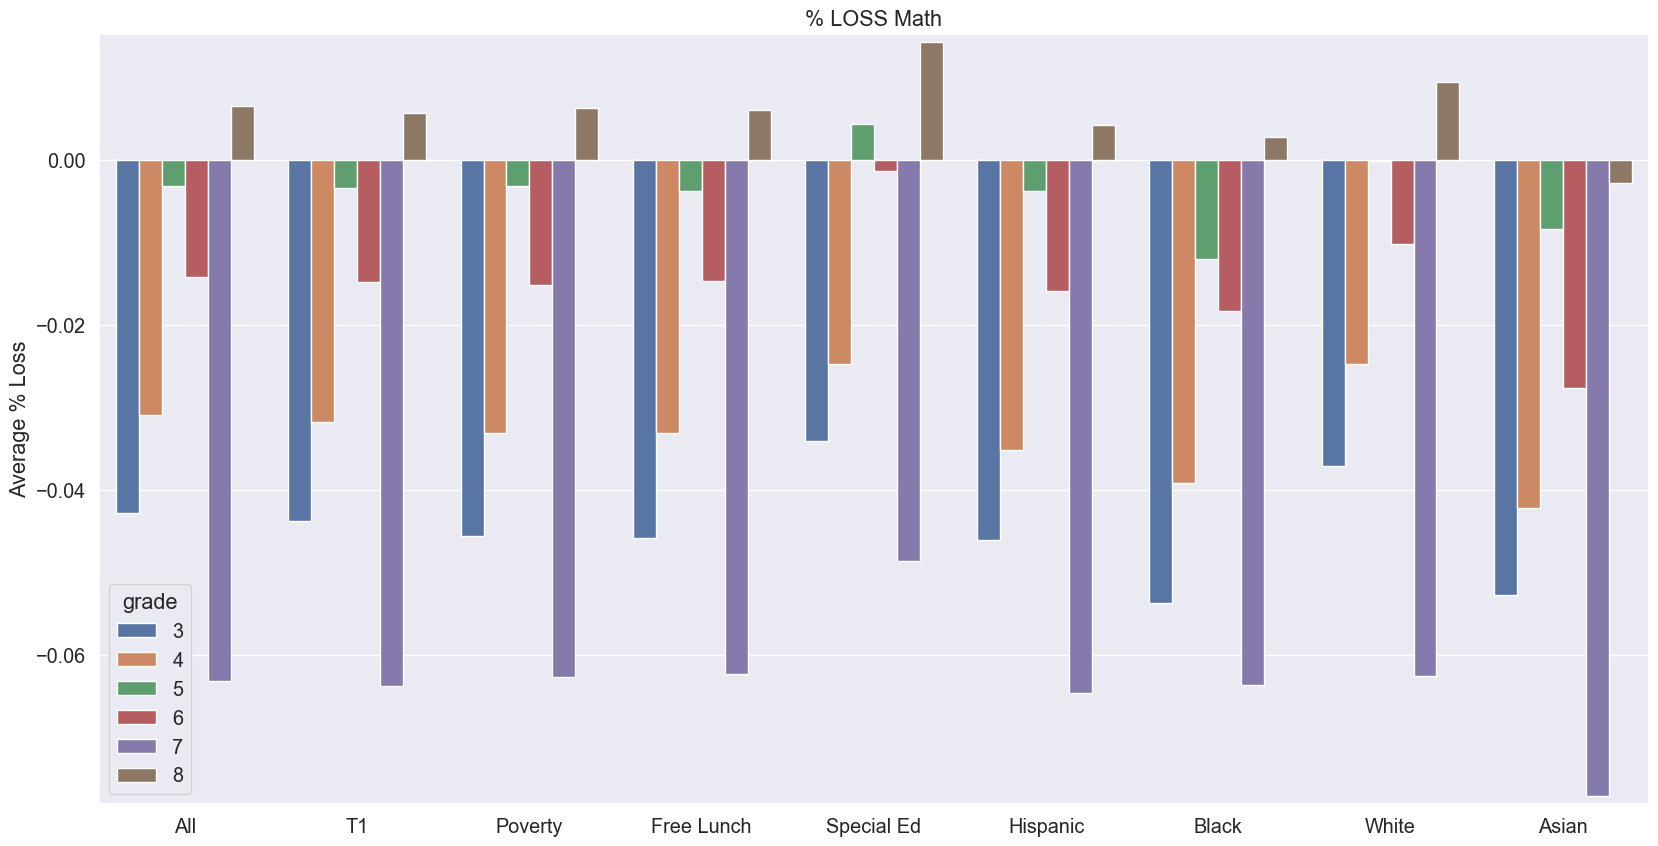

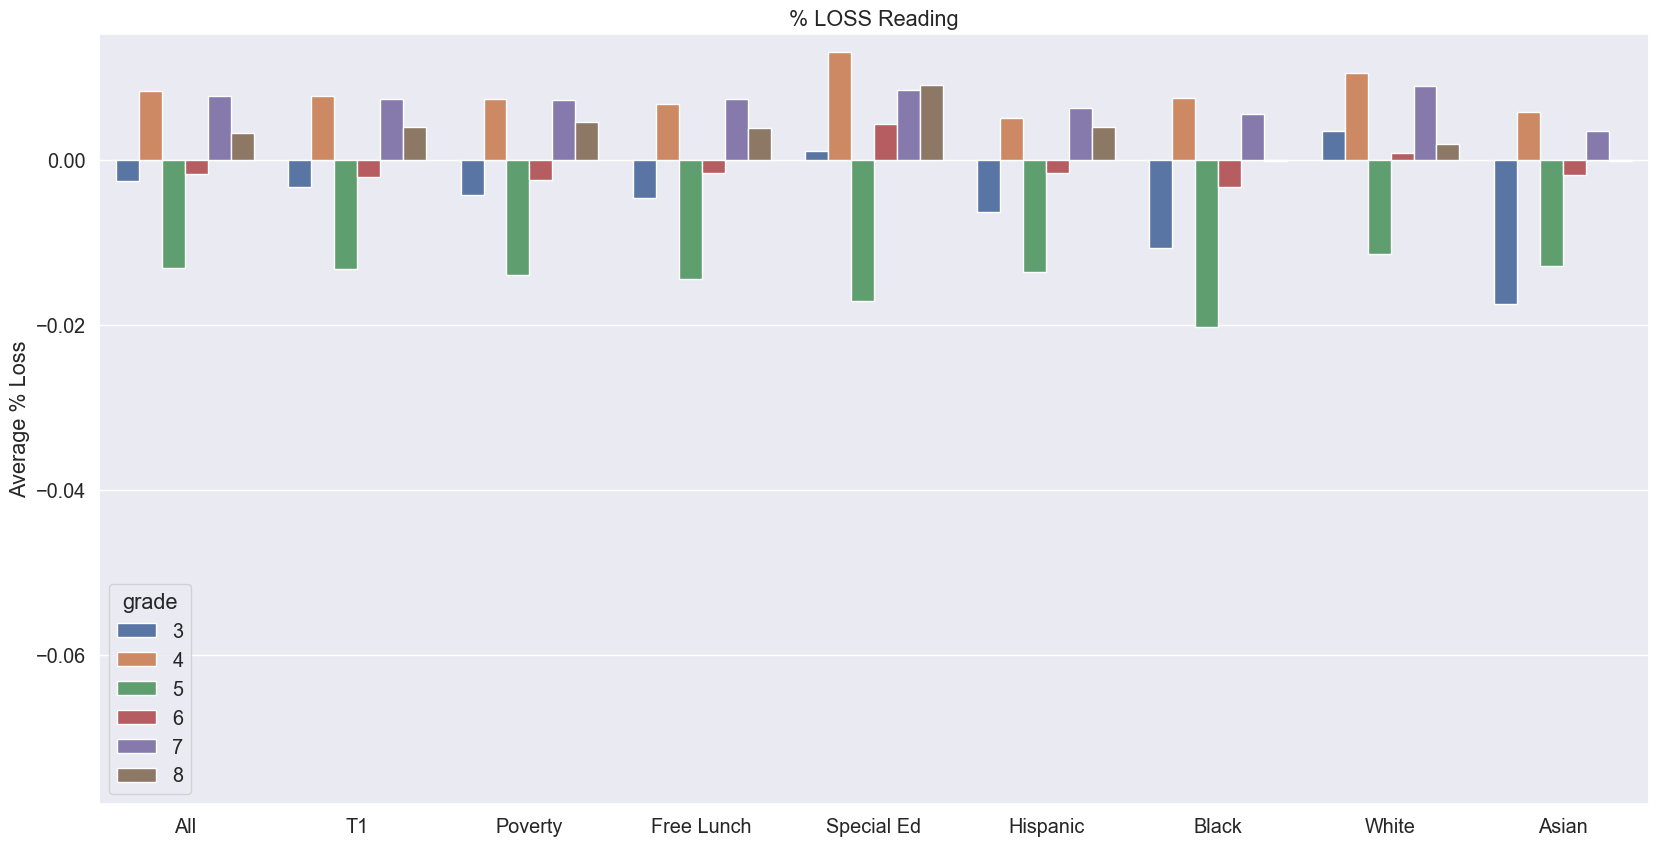

In [46]:
# For all districts in Texas
y = 'AVG'

# # For County Level: Hays ('County #' = 48209)
# y = 'AVG_County_48209'
# cols = df[df['County #'] == 48209]['District #'].to_list()
# df_loss_t[y] = df_loss_t[cols_hays].apply(lambda x: x.mean(), axis=1)

# # For District Level: Austin ISD ('District #' = 227901)
# y = 'AVG_District_227901'
# cols = [227901]
# df_loss_t[y] = df_loss_t.loc[:, cols].apply(lambda x: x.mean(), axis=1)

sns.set(rc={'figure.figsize':(20,10)})
sns.set_theme(style='whitegrid', palette='deep')
sns.set(font_scale=1.3)

for subject in ['Math', 'Reading']:
    data = df_loss_t[df_loss_t['subject'] == subject]
    g = sns.barplot(data=data, x="group", y=y, hue="grade", order=groups)
    g.set(title="% LOSS " + subject, xlabel="", ylabel='Average % Loss')
    g.set_ylim(df_loss_t[y].min() - 0.001, df_loss_t[y].max() + 0.001)
    plt.show()

- Learning Loss Difference by Grade

In [47]:
cols = ['Average Score Math All Grade 3 2018-2019',
                'Average Score Math All Grade 4 2018-2019',
                'Average Score Math All Grade 5 2018-2019',
                'Average Score Math All Grade 6 2018-2019',
                'Average Score Math All Grade 7 2018-2019',
                'Average Score Math All Grade 8 2018-2019',
                'Average Score Reading All Grade 3 2018-2019',
                'Average Score Reading All Grade 4 2018-2019',
                'Average Score Reading All Grade 5 2018-2019',
                'Average Score Reading All Grade 6 2018-2019',
                'Average Score Reading All Grade 7 2018-2019',
                'Average Score Reading All Grade 8 2018-2019',
                'Average Score Math All Grade 3 2020-2021',
                'Average Score Math All Grade 4 2020-2021',
                'Average Score Math All Grade 5 2020-2021',
                'Average Score Math All Grade 6 2020-2021',
                'Average Score Math All Grade 7 2020-2021',
                'Average Score Math All Grade 8 2020-2021',
                'Average Score Reading All Grade 3 2020-2021',
                'Average Score Reading All Grade 4 2020-2021',
                'Average Score Reading All Grade 5 2020-2021',
                'Average Score Reading All Grade 6 2020-2021',
                'Average Score Reading All Grade 7 2020-2021',
                'Average Score Reading All Grade 8 2020-2021']

df_copy = df[cols].agg('mean').to_frame()
df_copy.reset_index(inplace=True)
df_copy.rename(columns={0: 'Average Score'}, inplace=True)

df_copy['Year'] = df_copy['index'].apply(lambda x: int(x[-4:]))
df_copy['Subject'] = df_copy['index'].apply(lambda x: re.findall("Average Score (.+?)\s", x)[0])
df_copy['Grade'] = df_copy['index'].apply(lambda x: int(x[-11]))

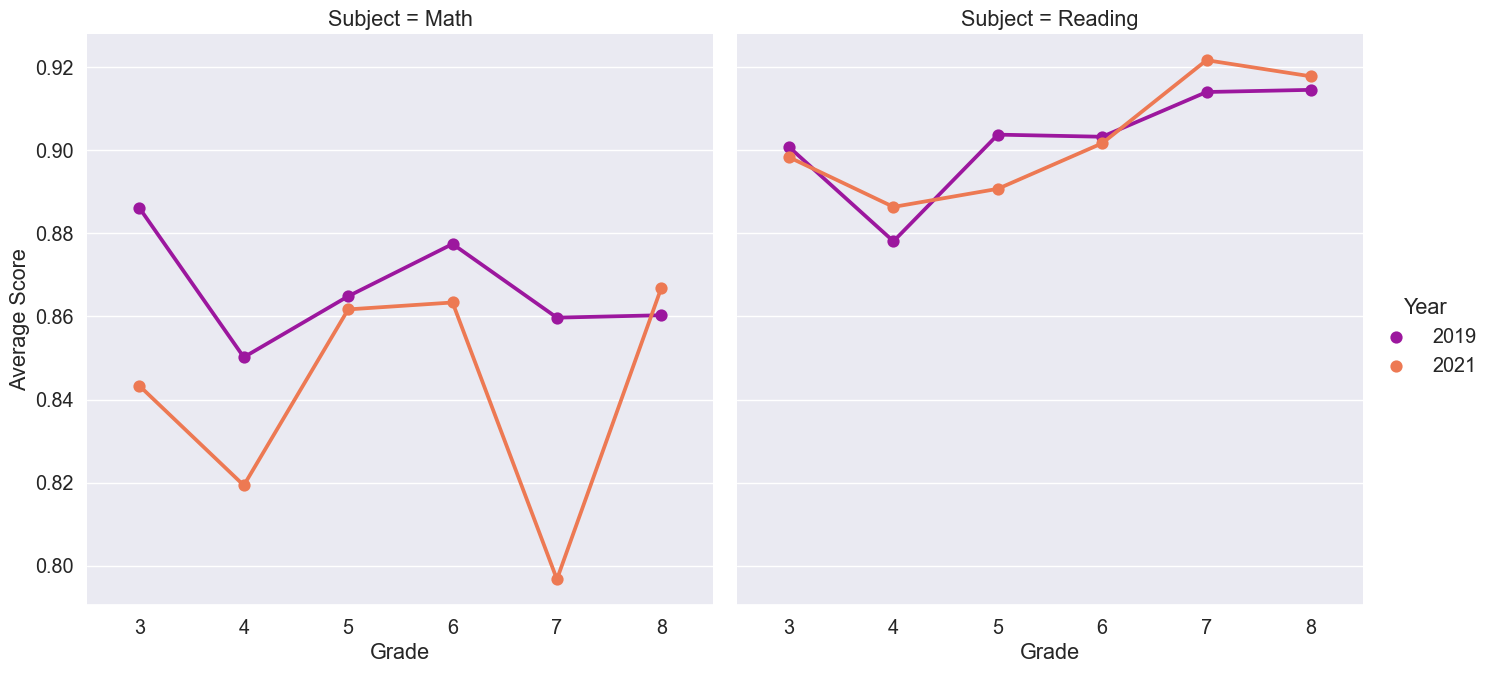

In [48]:
sns.set(rc={'figure.figsize':(20,20)})
sns.set_theme(style='whitegrid')
sns.set(font_scale=1.3)

g = sns.catplot(data=df_copy, x="Grade", y="Average Score", hue="Year", col="Subject",
                capsize=.2, palette="plasma", kind="point",
                height=7, aspect=1)
g.despine(left=True)
plt.show()

### Local Area Unemployment Statistics (LAUS) ###

In [49]:
df['LABEL'] = df['Label_Math']

df_temp1 = df[['LABEL', 'Unemployed Rate 19']].groupby('LABEL', as_index=False).agg('mean')
df_temp1.rename(columns={'Unemployed Rate 19': 'Unemployed Rate'}, inplace=True)
df_temp1['Year'] = 2019

df_temp2 = df[['LABEL', 'Unemployed Rate 21']].groupby('LABEL', as_index=False).agg('mean')
df_temp2.rename(columns={'Unemployed Rate 21': 'Unemployed Rate'}, inplace=True)
df_temp2['Year'] = 2021

df_math = pd.concat([df_temp1, df_temp2])
df_math['Subject'] = "Math"

df['LABEL'] = df['Label_Reading']

df_temp1 = df[['LABEL', 'Unemployed Rate 19']].groupby('LABEL', as_index=False).agg('mean')
df_temp1.rename(columns={'Unemployed Rate 19': 'Unemployed Rate'}, inplace=True)
df_temp1['Year'] = 2019

df_temp2 = df[['LABEL', 'Unemployed Rate 21']].groupby('LABEL', as_index=False).agg('mean')
df_temp2.rename(columns={'Unemployed Rate 21': 'Unemployed Rate'}, inplace=True)
df_temp2['Year'] = 2021

df_reading = pd.concat([df_temp1, df_temp2])
df_reading['Subject'] = "Reading"

df_copy = pd.concat([df_math, df_reading])

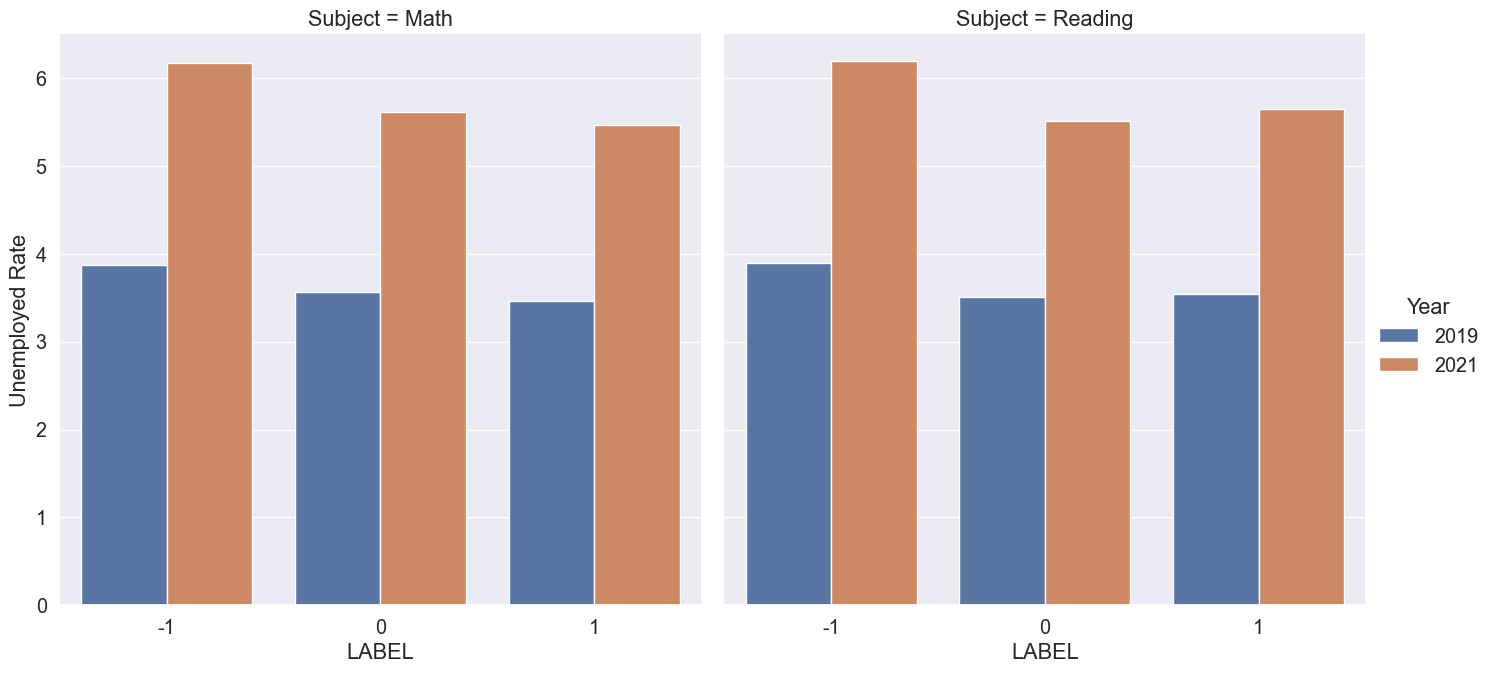

In [50]:
sns.set(rc={'figure.figsize':(20,20)})
sns.set_theme(style='whitegrid')
sns.set(font_scale=1.3)

g = sns.catplot(data=df_copy, x="LABEL", y="Unemployed Rate", hue="Year", col="Subject",
                capsize=.2, palette="deep", kind="bar",
                height=7, aspect=1)
g.despine(left=True)
plt.show()

### Census Block Group (County) 2010 TX ###

**Race/Ethnicity Groups of Population 2010 - Math**

In [51]:
df['LABEL'] = df['Label_Math']

cols = ['White Pop 10',
'Black Pop 10',
'Asian Pop 10',
'Hispanic Pop 10']
labels_race = ['White', 'Black', 'Asian', 'Hispanic']
temp = df.groupby(['County #'], as_index=False).agg({c: 'mean' for c in cols})
total_race = []
for c in cols: total_race.append(temp[c].sum())

cols = ['Male Pop 10', 'Female Pop 10']
labels_gender = ['Male', 'Female']
temp = df.groupby(['County #'], as_index=False).agg({c: 'mean' for c in cols})
total_gender = []
for c in cols: total_gender.append(temp[c].sum())

cols = ['Age 0-4 Pop 10',
'Age 5-9 Pop 10',
'Age 10-14 Pop 10',
'Age 15-19 Pop 10',
'Age 20-24 Pop 10',
'Age 25-34 Pop 10',
'Age 35-44 Pop 10',
'Age 45-54 Pop 10',
'Age 55-64 Pop 10',
'Age 65-74 Pop 10',
'Age 75-84 Pop 10',
'Age 85-Up Pop 10']
labels_age = [c.replace(' Pop 10', '') for c in cols]
temp = df.groupby(['County #'], as_index=False).agg({c: 'mean' for c in cols})
total_age = []
for c in cols: total_age.append(temp[c].sum())

cols = ['HH 1 Male 10',
'HH 1 Female 10',
'HH Married-Child 10',
'HH Married-noChild 10',
'HH Male-Child 10',
'HH Female-Child 10']
labels_hh = ['1-Person\nMale',
'1-Person\nFemale',
'Married Couple\nWith Children',
'Married Couple\nWith No Children',
'Male-Headed\nWith Children',
'Female-Headed\nWith Children']

temp = df.groupby(['County #'], as_index=False).agg({c: 'mean' for c in cols})
total_hh = []
for c in cols: total_hh.append(temp[c].sum())
    
cols = ['Housing Vacant 10',
'Housing Owner Occup 10',
'Housing Renter Occup 10']
labels_house = ['Vacant',
'Owner\nOccuppied',
'Renter\nOccuppied']

temp = df.groupby(['County #'], as_index=False).agg({c: 'mean' for c in cols})
total_house = []
for c in cols: total_house.append(temp[c].sum())

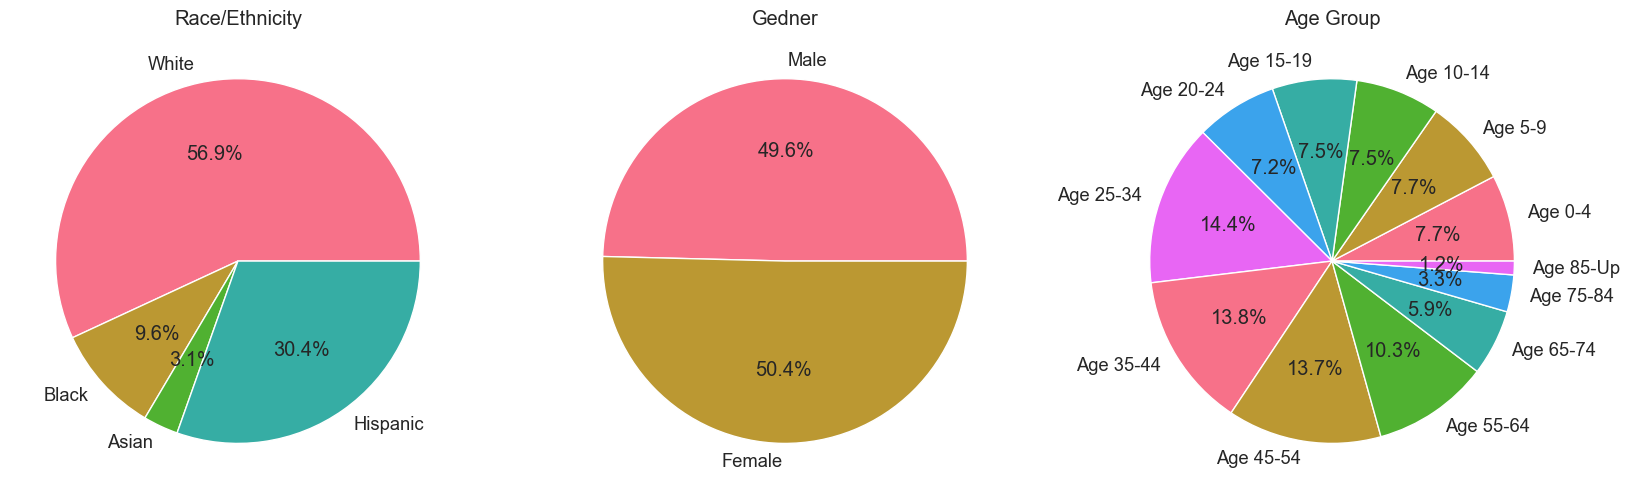

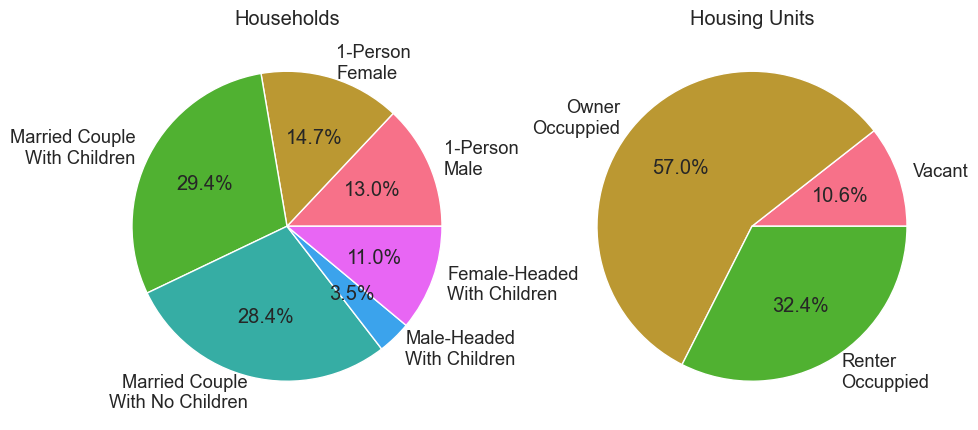

In [52]:
fig, axes = plt.subplots(1,3, figsize=(20,20))
sns.set(font_scale=1.2)

colors=sns.color_palette('husl')[:len(labels_race)]
axes[0].pie(total_race, labels=labels_race, colors=colors, autopct='%1.1f%%')
axes[0].set(title='Race/Ethnicity')

colors = sns.color_palette('husl')[:len(labels_gender)]
axes[1].pie(total_gender, labels=labels_gender, colors=colors, autopct='%1.1f%%')
axes[1].set(title='Gedner')

colors = sns.color_palette('husl')[:len(labels_age)]
axes[2].pie(total_age, labels=labels_age, colors=colors, autopct='%1.1f%%')
axes[2].set(title='Age Group')

fig, axes = plt.subplots(1,2, figsize=(11,6))

colors=sns.color_palette('husl')[:len(labels_hh)]
axes[0].pie(total_hh, labels=labels_hh, colors=colors, autopct='%1.1f%%')
axes[0].set(title='Households')

colors = sns.color_palette('husl')[:len(labels_house)]
axes[1].pie(total_house, labels=labels_house, colors=colors, autopct='%1.1f%%')
axes[1].set(title='Housing Units')
    
plt.show()

### Race/Ethnicity Census - Math ###

In [53]:
df['LABEL'] = df['Label_Math']

cols = ['Asian Pop 10','Black Pop 10','Hispanic Pop 10','White Pop 10']

df_copy = df[['LABEL'] + cols].groupby('LABEL', as_index=False).agg('mean')

labels = ['Asian', 'Hispanic', 'Black', 'White']

# for label, loc in zip(labels, np.arange(0, len(cols), 2)):
#     df_copy[label] = df_copy[cols[loc:loc+2]].mean(axis=1)

total = []
for race in cols: total.append(df_copy[race].sum())

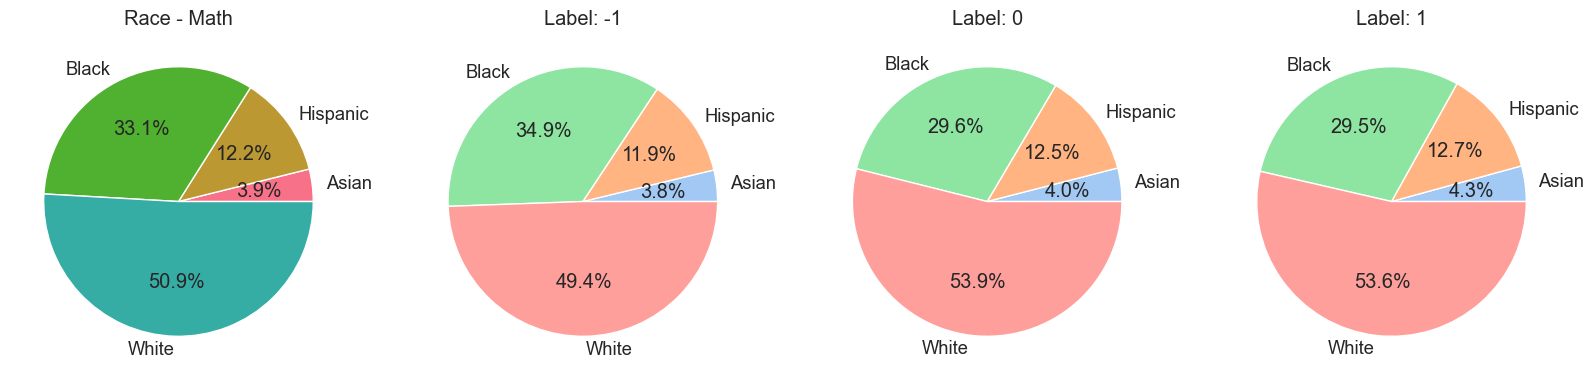

In [54]:
fig, axes = plt.subplots(1,df_copy.shape[0]+1, figsize=(20,20))
sns.set(font_scale=1.2)

colors=sns.color_palette('husl')[:len(labels)]
axes[0].pie(total, labels=labels, colors=colors, autopct='%1.1f%%')
axes[0].set(title='Race - Math')

colors = sns.color_palette('pastel')[:len(labels)]

for loc in range(df_copy.shape[0]):
    axes[loc+1].pie(df_copy[cols].loc[loc], labels=labels, colors=colors, autopct='%1.1f%%')
    axes[loc+1].set(title='Label: ' + str(df_copy['LABEL'][loc]))
    
plt.show()

### Race/Ethnicity Census - Reading ###

In [55]:
df['LABEL'] = df['Label_Reading']

cols = ['Asian Pop 10','Black Pop 10','Hispanic Pop 10','White Pop 10',]

df_copy = df[['LABEL'] + cols].groupby('LABEL', as_index=False).agg('mean')

labels = ['Asian', 'Hispanic', 'Black', 'White']

total = []
for race in cols: total.append(df_copy[race].sum())

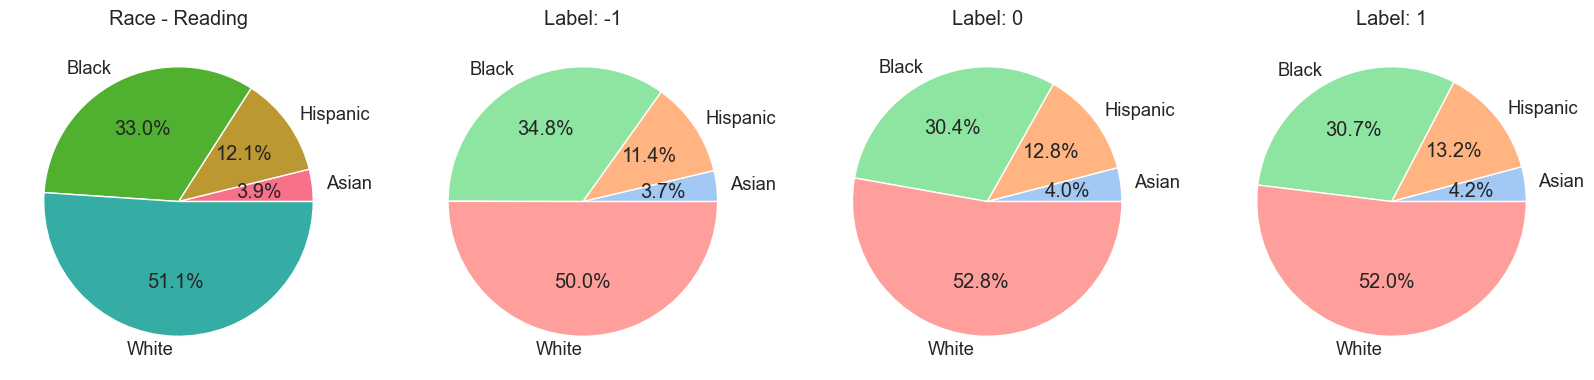

In [56]:
fig, axes = plt.subplots(1,df_copy.shape[0]+1, figsize=(20,20))
sns.set(font_scale=1.2)

colors=sns.color_palette('husl')[:len(labels)]
axes[0].pie(total, labels=labels, colors=colors, autopct='%1.1f%%')
axes[0].set(title='Race - Reading')

colors = sns.color_palette('pastel')[:len(labels)]

for loc in range(df_copy.shape[0]):
    axes[loc+1].pie(df_copy[cols].loc[loc], labels=labels, colors=colors, autopct='%1.1f%%')
    axes[loc+1].set(title='Label: ' + str(df_copy['LABEL'][loc]))
    
plt.show()

### ESSER Grants ###

In [57]:
df['LABEL'] = df['Label_Math']

cols = ['CARES ESSER I 20',
'CRRSA ESSER II 21',
'ARP ESSER III 21',
'ESSER-SUPP 22',
'ESSER-SUPP 23']

df_copy = df[['LABEL'] + cols].groupby('LABEL', as_index=False).agg('sum')

df_copy2=pd.DataFrame()
for c in cols:
    temp=df_copy[['LABEL', c]].copy()
    temp.rename(columns={c: 'Amount'}, inplace=True)
    temp['Grant']=c
    temp['Subject']='Math'
    df_copy2=pd.concat([df_copy2, temp])
    
df['LABEL'] = df['Label_Reading']

df_copy = df[['LABEL'] + cols].groupby('LABEL', as_index=False).agg('sum')

for c in cols:
    temp=df_copy[['LABEL', c]].copy()
    temp.rename(columns={c: 'Amount'}, inplace=True)
    temp['Grant']=c
    temp['Subject']='Reading'
    df_copy2=pd.concat([df_copy2, temp])

In [64]:
df_copy2['Label']=df_copy2['LABEL'].apply(lambda x: 'Loss' if x==-1
                                          else 'Expected' if x==0
                                          else 'Gain')

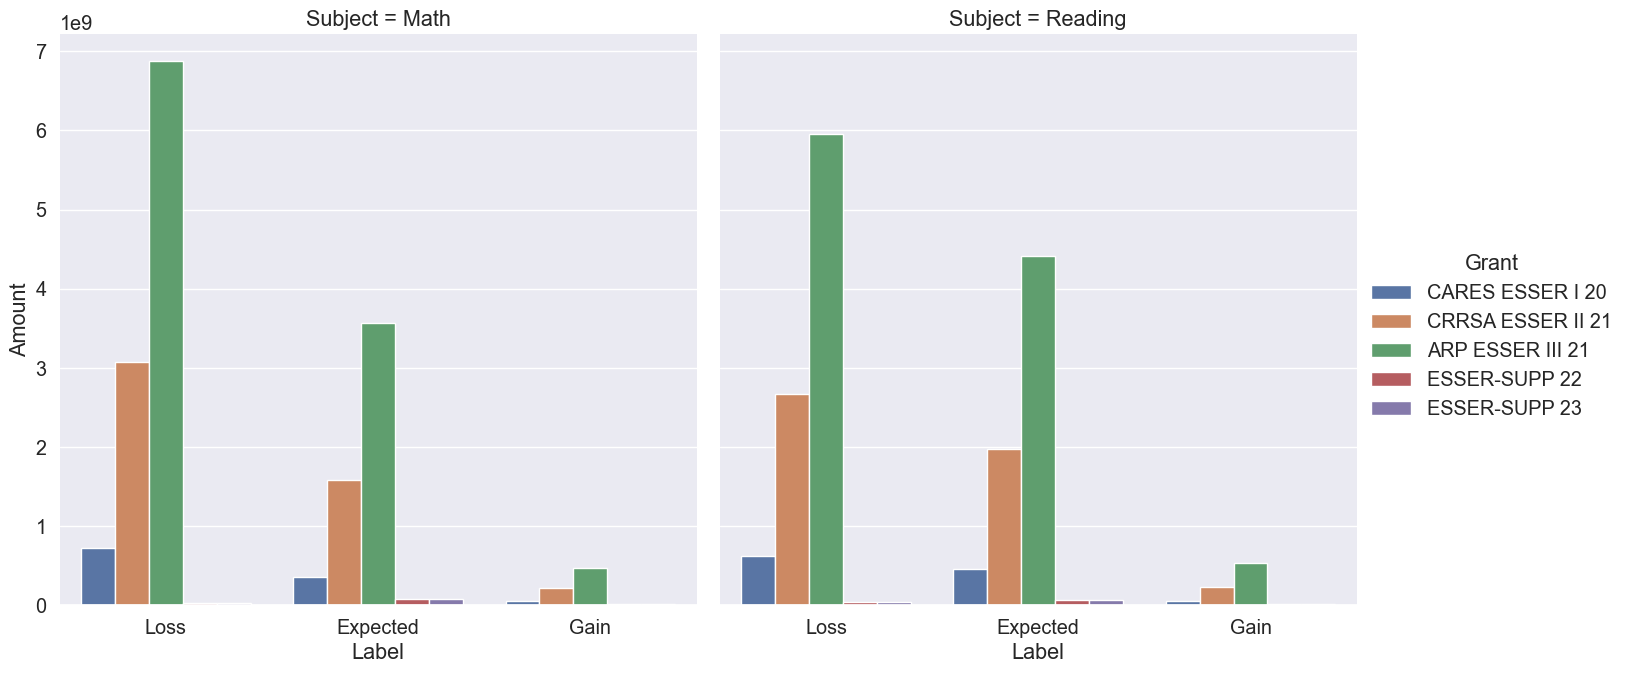

In [65]:
sns.set(rc={'figure.figsize':(20,20)})
sns.set_theme(style='whitegrid')
sns.set(font_scale=1.3)

g = sns.catplot(data=df_copy2, x="Label", y="Amount", hue="Grant", col="Subject",
                capsize=.2, palette="deep", kind="bar",
                height=7, aspect=1)
g.despine(left=True)
plt.show()